# Importing the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar, Simulator
from pyomo.opt import SolverFactory
from pyomo.contrib.parmest import parmest # import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
import idaes.core.solvers.get_solver   # import the idaes solvers

# Data

Table S1. Initial guesses for the kinetic parameter values used to test the sensitivity of MBDoE to the initial parameter
estimates (both Ramp F and Ramp FT scenarios).

## Parameter: initial guess

In [2]:
# theta_init = {
#     "Parameter Set": ["Factorial Estimates", "A", "B", "C", "D"],
#     "KP1": [9.12, 8.5, 9.5, 8.5, 9.5],
#     "KP2": [7.98, 6.0, 11, 10, 7.0],
#     "k0 (s^-1)": ["1.17E+07", "3.95E+04", "1.17E+11", "1.32E+10", "3.49E+05"],
#     "EA (J/mol)": [79800, 60000, 110000, 100000, 70000],
#     "k at 100°C (*10^5 s^-1)": [0.78, 1.58, 0.47, 1.33, 0.56],
#     "k at 120°C (*10^5 s^-1)": [2.88, 4.21, 2.84, 6.85, 1.75],
#     "k at 140°C (*10^5 s^-1)": [9.40, 10.25, 14.50, 30.11, 4.94]
# }

# theta_init = pd.DataFrame(theta_init)
# theta_init.columns = ['Parameter Set', 'KP1', 'KP2', 'k0', 'EA',
#        'k@100C', 'k@120C', 'k@140C']
# theta_init


## Flowrate ramp at 119°C and $C_F$ = 1.56M

Table S2. Time each sample was measured, left and entered the reactor and corresponding reaction time,
along with conversion and outlet concentrations of benzoic acid and ethyl benzoate for the first MBDoE Ramp
F experiment. The initial flowrate was 29.8 µL/min, the flowrate was ramped down at a rate of 0.253 µL/min2
, while the temperature was held constant at 119°C and the feed concentration was 1.56 M.

In [3]:
data_FR1 = {
    "tM,i Time the sample was measured (s)": [408, 828, 1248, 1667, 2084, 2504, 2923, 3342, 3763, 4182, 4603, 5024, 5444, 5864],
    "tIn,i Time the sample entered the reactor (s)": [110, 511, 910, 1304, 1693, 2080, 2460, 2833, 3198, 3549, 3885, 4199, 4481, 4722],
    "tL,i Time the sample left the reactor (s)": [314, 728, 1141, 1552, 1959, 2368, 2774, 3177, 3578, 3972, 4360, 4736, 5094, 5422],
    "τi Sample reaction time (s)": [204, 217, 231, 248, 267, 288, 314, 344, 380, 422, 474, 537, 613, 700],
    "X Conversion (%)": [5.8, 5.8, 6.4, 7.1, 7.1, 7.7, 8.3, 9.0, 9.6, 10.9, 12.2, 13.5, 14.7, 16.7],
    "Outlet Concentration Benzoic Acid (M)": [1.47, 1.47, 1.46, 1.45, 1.45, 1.44, 1.43, 1.42, 1.41, 1.39, 1.37, 1.35, 1.33, 1.30],
    "Outlet Concentration Ethyl Benzoate (M)": [0.09, 0.09, 0.10, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.18, 0.20, 0.23, 0.25]
}

ramp_F1 = pd.DataFrame(data_FR1)
ramp_F1.columns = columns=["t_m(s)", "t_in(s)", "t_L(s)", "tau(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
# adding the temperature to the data
ramp_F1["T(C)"] = 119
# adding the feed concentration to the data
ramp_F1["C_F(M)"] = 1.56

# adding the ramped flowrate to the data
initial_flowrate = 29.8  # µL/min
ramp_rate = 0.253  # µL/min^2

# Calculate the time elapsed since the start of the ramp
time_elapsed = ramp_F1['t_in(s)']

# Calculate the flowrate at each time point
ramp_F1['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)
ramp_F1

,t_m(s),t_in(s),t_L(s),tau(s),X(%),C_BA(M),C_EB(M),T(C),C_F(M),F(µL/min)
0,408,110,314,204,5.8,1.47,0.09,119,1.56,29.336167
1,828,511,728,217,5.8,1.47,0.09,119,1.56,27.645283
2,1248,910,1141,231,6.4,1.46,0.10,119,1.56,25.962833
3,1667,1304,1552,248,7.1,1.45,0.10,119,1.56,24.301467
4,2084,1693,1959,267,7.1,1.45,0.11,119,1.56,22.661183
5,2504,2080,2368,288,7.7,1.44,0.12,119,1.56,21.029333
6,2923,2460,2774,314,8.3,1.43,0.13,119,1.56,19.427000
7,3342,2833,3177,344,9.0,1.42,0.14,119,1.56,17.854183
8,3763,3198,3578,380,9.6,1.41,0.15,119,1.56,16.315100
9,4182,3549,3972,422,10.9,1.39,0.17,119,1.56,14.835050


In [4]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_F1["t_m(s)"], ramp_F1["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_F1["t_m(s)"], ramp_F1["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_F1["t_m(s)"], ramp_F1["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_F1["t_m(s)"], ramp_F1["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_F1["t_m(s)"], ramp_F1["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 119°C and 1.56 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

## Flowrate ramp at 139.4C and $C_F$ = 1.55 M

Table S3. Time each sample was measured, left and entered the reactor and corresponding reaction time,
along with conversion and outlet concentrations of benzoic acid and ethyl benzoate for the second MBDoE
Ramp F experiment. The initial flowrate was 9.13 µL/min, the flowrate was ramped down at a rate of 0.043
µL/min2, while the temperature was held constant at 139.4 oC and the feed concentration was 1.55 M.  

In [5]:
data_FR2 = {
    "Time the sample was measured (t_M,i)": [152, 571, 991, 1411, 1830, 2251, 2670, 3090, 3510, 3931, 4350, 4770, 5190, 5610],
    "Time the sample entered the reactor (t_In,i)": [None, None, 17, 404, 787, 1170, 1549, 1925, 2298, 2668, 3033, 3393, 3749, 4098],
    "Time the sample left the reactor (t_L,i)": [None, 271, 680, 1089, 1496, 1904, 2309, 2714, 3117, 3520, 3920, 4318, 4715, 5109],
    "Sample reaction time (τ_i)": [623, 643, 663, 685, 709, 734, 760, 789, 819, 852, 887, 925, 966, 1010],
    "Conversion (X)": [44.9, 45.5, 46.2, 47.4, 48.1, 48.7, 50.0, 51.3, 51.9, 53.8, 55.1, 56.4, 57.7, 59.0],
    "Outlet Concentration Benzoic Acid (M)": [0.86, 0.85, 0.84, 0.82, 0.81, 0.80, 0.78, 0.76, 0.75, 0.72, 0.70, 0.68, 0.66, 0.64],
    "Outlet Concentration Ethyl Benzoate (M)": [0.70, 0.70, 0.72, 0.73, 0.74, 0.76, 0.78, 0.79, 0.81, 0.83, 0.86, 0.87, 0.90, 0.92]
}

ramp_F2 = pd.DataFrame(data_FR2)
ramp_F2.columns = columns=["t_m(s)", "t_in(s)", "t_L(s)", "tau(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
# adding the temperature to the data
ramp_F2["T(C)"] = 139.4 #oC
# adding the feed concentration to the data
ramp_F2["C_F(M)"] = 1.55  # M

# adding the ramped flowrate to the data
initial_flowrate = 9.13  # µL/min
ramp_rate = 0.043  # µL/min

# Calculate the time elapsed since the start of the ramp
time_elapsed = ramp_F2['t_m(s)']

# Calculate the flowrate at each time point
ramp_F2['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)
ramp_F2 = ramp_F2.dropna(ignore_index=True)  # our data contains NaN values, we are dropping them
ramp_F2


,t_m(s),t_in(s),t_L(s),tau(s),X(%),C_BA(M),C_EB(M),T(C),C_F(M),F(µL/min)
0,991,17.0,680.0,663,46.2,0.84,0.72,139.4,1.55,8.419783
1,1411,404.0,1089.0,685,47.4,0.82,0.73,139.4,1.55,8.118783
2,1830,787.0,1496.0,709,48.1,0.81,0.74,139.4,1.55,7.818500
3,2251,1170.0,1904.0,734,48.7,0.80,0.76,139.4,1.55,7.516783
4,2670,1549.0,2309.0,760,50.0,0.78,0.78,139.4,1.55,7.216500
5,3090,1925.0,2714.0,789,51.3,0.76,0.79,139.4,1.55,6.915500
6,3510,2298.0,3117.0,819,51.9,0.75,0.81,139.4,1.55,6.614500
7,3931,2668.0,3520.0,852,53.8,0.72,0.83,139.4,1.55,6.312783
8,4350,3033.0,3920.0,887,55.1,0.70,0.86,139.4,1.55,6.012500
9,4770,3393.0,4318.0,925,56.4,0.68,0.87,139.4,1.55,5.711500


In [6]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_F2["t_m(s)"], ramp_F2["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_F2["t_m(s)"], ramp_F2["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_F2["t_m(s)"], ramp_F2["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_F2["t_m(s)"], ramp_F2["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_F2["t_m(s)"], ramp_F2["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 139.4°C and 1.55 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

## Flowrate and Temperature ramp

Table S4. Time each sample was measured, left and entered the reactor, corresponding reaction time, and the
reactor temperature at the time the samples entered and left the reactor, along with conversion and outlet
concentrations of benzoic acid and ethyl benzoate for the MBDoE Ramp FT experiment. The initial flowrate
was 10.1 µL/min, the flowrate was ramped down at a rate of 0.05 µL/min2
, while the initial temperature was
139.2 °C, and it was ramped down at a rate of 0.537 °C/min. The feed concentration of benzoic acid was held
constant at 1.56 M. 
  
This data has some issues. We can see that `t_L` is less than `tau`, which shouldn't be the case. In the model, we will set `t_L` = `t_in` + `tau` as a measure to address this issue.

In [7]:
data_FT = {
    "Time the sample was measured (s)": [419, 840, 1260, 1679, 2099, 2519, 2939, 3359, 3779, 4199, 4619, 5038, 5457, 5876],
    "Time the sample entered the reactor (s)": [np.nan, np.nan, 354, 739, 1124, 1505, 1883, 2258, 2629, 2996, 3358, 3714, 4064, 4407],
    "Time the sample left the reactor (s)": [np.nan, 150, 561, 971, 1379, 1786, 2193, 2599, 3003, 3406, 3807, 4206, 4602, 4995],
    "Sample reaction time (s)": [577, 596, 617, 639, 663, 688, 716, 745, 777, 811, 848, 888, 931, 979],
    "Reactor temperature at time tini (°C)": [139.2, 139.2, 136.0, 132.6, 129.1, 125.7, 122.3, 119.0, 115.7, 112.4, 109.1, 106.0, 102.8, 99.8],
    "Reactor temperature at time tLi (°C)": [139.2, 134.2, 130.5, 126.9, 123.2, 119.6, 115.9, 112.3, 108.7, 105.1, 101.6, 98.0, 94.5, 91.0],
    "X Conversion (%)": [41.5, 39.6, 35.1, 31.2, 26.7, 23.5, 19.7, 17.1, 14.5, 12.6, 10.0, 8.7, 7.5, 6.2],
    "Outlet Conc. Benzoic Acid (M)": [0.91, 0.94, 1.01, 1.07, 1.14, 1.19, 1.25, 1.29, 1.33, 1.36, 1.40, 1.42, 1.44, 1.46],
    "Outlet Conc. Ethyl Benzoate (M)": [0.64, 0.62, 0.55, 0.49, 0.42, 0.37, 0.31, 0.27, 0.22, 0.19, 0.16, 0.13, 0.11, 0.09]
}

ramp_FT = pd.DataFrame(data_FT)
ramp_FT.columns = columns=["t_m(s)", "t_in(s)", "t_L(s)", "tau(s)", "T_in(C)", "T_L(C)", "X(%)", "C_BA(M)", "C_EB(M)"]

# adding the temperature to the data
T_ramp_rate = 0.537 # °C/min
time_elapsed = ramp_FT['t_in(s)']

# adding the feed concentration to the data
ramp_FT["C_F(M)"] = 1.56  # M

# adding the ramped flowrate to the data
initial_flowrate = 10.1  # µL/min
ramp_rate = 0.05 # µL/min^2

ramp_FT = ramp_FT.dropna(ignore_index=True)

# # Calculate the flowrate at each time point
# ramp_FT['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)

ramp_FT

,t_m(s),t_in(s),t_L(s),tau(s),T_in(C),T_L(C),X(%),C_BA(M),C_EB(M),C_F(M)
0,1260,354.0,561.0,617,136.0,130.5,35.1,1.01,0.55,1.56
1,1679,739.0,971.0,639,132.6,126.9,31.2,1.07,0.49,1.56
2,2099,1124.0,1379.0,663,129.1,123.2,26.7,1.14,0.42,1.56
3,2519,1505.0,1786.0,688,125.7,119.6,23.5,1.19,0.37,1.56
4,2939,1883.0,2193.0,716,122.3,115.9,19.7,1.25,0.31,1.56
5,3359,2258.0,2599.0,745,119.0,112.3,17.1,1.29,0.27,1.56
6,3779,2629.0,3003.0,777,115.7,108.7,14.5,1.33,0.22,1.56
7,4199,2996.0,3406.0,811,112.4,105.1,12.6,1.36,0.19,1.56
8,4619,3358.0,3807.0,848,109.1,101.6,10.0,1.40,0.16,1.56
9,5038,3714.0,4206.0,888,106.0,98.0,8.7,1.42,0.13,1.56


In [8]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_FT["t_m(s)"], ramp_FT["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_FT["t_m(s)"], ramp_FT["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_FT["t_m(s)"], ramp_FT["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_FT["t_m(s)"], ramp_FT["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_FT["t_m(s)"], ramp_FT["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 139.4°C and 1.55 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

# Model

**Reaction:** 
            $$\text{Benzoid Acid + Ethanol = Ethyl Benzoate + Water}$$

**Reactor and feed parameters:**  
$\qquad d, \: \text{reactor diameter = } 250\times 10^{-5} dm\\$
$\qquad l, \: \text{length of the reactor = } 20 \, dm \\$
$\qquad \nu $, volumetric flow rate, $L/min\\$
$\qquad \nu_0 \text{, initial volumetric flow rate = } 29.8\times 10 ^{-6} L/min\\$
$\qquad C_{BA}  \text{ concentration of benzoic acid,} 1.56 M\\$
$\qquad \alpha_v \text{, volumetric ramp rate = }-0.253\times 10 ^{-6} L/min^2$  
$\qquad z \rightarrow$ distance from the entrance of the reactor, $ dm$


**1. Model**  
Material Balance for a transient Plug Flow Reactor (PFR):


\begin{equation}
\frac{\partial C_{BA}}{\partial t} = - \nu (t) \frac{\partial C_{BA}}{\partial V} + r_{BA} \tag{1}
\end{equation}


Substituting $V = A_C z$ and $r_{BA} = - k C_{BA}$ into equation (1):


\begin{equation}
\frac{\partial C_{BA}}{\partial t} = - \frac{\nu(t)}{A_c} \frac{\partial C_{BA}}{\partial z} - k C_{BA} \tag{2}
\end{equation}


The expression for the reaction rate constant, $k$, is given by:


\begin{equation}
k = \exp \left(-KP1 - \frac{KP2 \times 10000}{R} \times \left[ \frac{1}{T} - \frac{1}{T_M}\right]\right) \tag{3}
\end{equation}


The expression for the ramped flow rate, $\nu(t)$, is:


\begin{equation}
\nu(t) = \nu_0 - \alpha_\nu t \tag{4}
\end{equation}


**Parameters to estimate:** $KP1, KP2\\$
**Design variables:** $\nu, C_{BA0}, T$

**2. Boundary and initial conditions**  
Boundary Condition at the Reactor Inlet (z=0)
$$
C_{BA}(t ≥ t_0, z = 0) = C_{BA0}  \tag{5}
$$
where, $t_0$ is the time at which the reactant reaches the reactor inlet.

Initially there was no benzoic acid in the PFR.  
$$
C_{BA}(t = 0, z) = 0  \tag{6}
$$




## Space time and feed velocity

In [9]:
# area = np.pi * (250e-5 /2)**2  # dm^2
# length = 20 # dm
# Volume = area * length  # L
# volumetric_flowrate = 29.8e-6  # L/min
# space_time = Volume / volumetric_flowrate  # min
# velocity = volumetric_flowrate / (area * 10 * 60) # dm/s
# print("space time: {a: 0.3f} min".format(a=space_time))
# print("velocity: %0.4f dm/s" %velocity)

# Simulating the Reactor with literature parameter data
## Steady-State PFR

In [10]:
# # Simulating steady state model
# nfe =50 # number of finite elements
# # SIMULATING THE MODEL USING IPOPT
# def BA_kinetics_ss():
#     m = pyo.ConcreteModel()

#     # Conversion factors
#     m.SEC2MIN = 1 / 60  # seconds to minutes
    
#     # Define sets
#     m.t = ContinuousSet(bounds=(0, 3.294455383378558))  # reaction time in minutes, upper bound = spce_time

#     # Define variables
#     m.C_BA = pyo.Var(m.t, initialize=1.56)  # benzoic acid concentration in M

#     # Define derivative variables
#     m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)

#     # Define parameters
#     m.k =  pyo.Param(initialize = (10e-5 / m.SEC2MIN))  # reaction rate constant, min^-1


#     # TODO: replace these hyperparameters with `initial_values` in the `__init__` constructor
#     # hyperparameters       
#     m.C_BA0 = pyo.Param(initialize=1.56)  # initial benzoic acid concentration, M

               
#     # Define the differential equations
#     @m.Constraint(m.t)
#     def _ideal_pfr_eqn(m, t):
#         # if t == 0:
#         #     return pyo.Constraint.Skip
#         # else:
#         return (
#                 m.dC_BA_dt[t] == - m.k * m.C_BA[t]
#             )  # PDE of the concentration of BA

      
#     # Boundary and initial conditions
#     # m.C_BA[0].fix(m.C_BA0) 
#     @m.Constraint()
#     def _inlet_conc(m):
#         return m.C_BA[0] == m.C_BA0


#     # Discretize the model using finite difference
#     pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=nfe, scheme="FORWARD", wrt=m.t)  # discretize wrt time

#     # Let's define initial conditions for z>0
#     # for z in m.z:
#     #     if z > 0:
#     #         m.C_BA[0, z].fix(0)
        
    
#     # m.pprint()
#     # Solve the model
   
#     solver = SolverFactory("ipopt")
#     solver.options["linear_solver"] = "MA57"
#     solver.options["max_iter"] = 100
#     res = solver.solve(m, tee=True)

#     return res, m  # return the results and the model

# result, model = BA_kinetics_ss()

# # Extract results
# t_vals = list(model.t)
# C_BA_vals = [model.C_BA[t]() for t in t_vals]

# # Plot the concentration profile
# plt.plot(t_vals, C_BA_vals, label='C_BA(t)')
# plt.xlabel('time')
# plt.ylabel('Concentration (M)')
# plt.title('PFR Concentration Profile')
# plt.legend()
# plt.grid()
# plt.show()

## Transient PFR

In [11]:
# nfe_t = 200# number of finite elements
# nfe_z = 200 # number of finite elements
# # SIMULATING THE MODEL USING IPOPT
# def BA_kinetics():
#     m = pyo.ConcreteModel()

#     # Conversion factors
#     m.SEC2MIN = 1 / 60  # seconds to minutes
#     m.R = 8.314  # universal gas constant, J/mol/K
#     m.TM = 378.15
#     m.T = 119 + 273.15  # temperature of the reactor, K

#     # Define sets
#     m.Length = 2
#     m.t = ContinuousSet(bounds=(0, 0.8))  # reaction time in minutes, upper bound = spce_time
#     m.z = ContinuousSet(bounds=(0, m.Length))
#     # m.t = ContinuousSet(bounds=(0, 4))  # reaction time in minutes, upper bound = spce_time
#     # m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor: 20 dm

#     # Define variables
#     m.C_BA = pyo.Var(m.t, m.z, initialize=1e-8, bounds=(0, 1.56))  # benzoic acid concentration in M

#     # Define derivative variables
#     m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
#     m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

#     # Define parameters
#     # initial guess from the paper
#     # m.KP1 = 9.12
#     # m.KP2 = 7.98
#     # Optimized from our pfr model
#     m.KP1 =  8.847856  # dimensionless
#     m.KP2 =  3.973650   # J/mol
#     m.k0 = pyo.Expression(expr= pyo.exp(-m.KP1 + m.KP2 * 10000 / (m.R * m.TM)))
#     # equation for activation energy, EA
#     m.EA = pyo.Expression(expr= m.KP2 * 10000)
#     # equation for the Arrhenius equation
#     m.k = pyo.Expression(expr= pyo.exp(-m.KP1 - (m.KP2 * 10000 / m.R) * (1 / m.T - 1 / m.TM)) / m.SEC2MIN)

#     # hyperparameters
#     m.alpha_v = pyo.Param(initialize= - 0.253e-6) # flowrate ramp, L/min^2
#     m.v0 = pyo.Var(initialize=29.8e-6)  # initial flowrate, L/min    
#     m.v = pyo.Var(m.t, initialize=29.8e-6)  # flowrate, L
#     m.C_BA0 = pyo.Param(initialize=1.56)  # initial benzoic acid concentration, M

#     # Constants
#     m.d = 250e-5  # diameter of the reactor, dm (decimeters)
#     m.Ac = np.pi * (m.d / 2) ** 2  # Reactor cross-sectional area, dm^2

#     # Define the differential equations
#     @m.Constraint(m.t, m.z)
#     def _pde_eqn(m, t, z):
#         if z == 0:
#             return pyo.Constraint.Skip   # we skip the PDE at z=0, b/c at z=0 the feed just entered and the conc does not change with time
#         else:
#             return (
#                     m.dC_BA_dt[t, z] == - (m.v[t] / m.Ac) * m.dC_BA_dz[t, z] - m.k * m.C_BA[t, z]
#                 )  # PDE of the concentration of BA
        
#         # ramping the flowrate
#     @m.Constraint(m.t)
#     def flowrate_ramp(m, t):
#         return m.v[t] == m.v0 - m.alpha_v * t # L/min. 
#         # Note: only `self.t_in` is converted to min, b/c `m.t` is already in min.


#     # @m.Constraint(m.t, m.z)
#     # def _pde_eqn(m, t, z):
#     #     return (
#     #             m.dC_BA_dt[t, z] == - (m.v0 / m.Ac) * m.dC_BA_dz[t, z] - m.k * m.C_BA[t, z]
#     #         )  # PDE of the concentration of BA

#     # Boundary conditions
#     @m.Constraint(m.t)
#     def _inlet_conc(m, t):
#         return m.C_BA[t, 0] == m.C_BA0

#     # @m.Constraint(m.t)
#     # def _der_at_z20(m, t):
#     #     return m.dC_BA_dz[t, 20] == 0

#     # Discretize the model using finite difference
#     discr_method = "dae.finite_difference"
#     scheme = "BACKWARD"
#     ncp=3
#     if discr_method == "dae.finite_difference":
#         pyo.TransformationFactory(discr_method).apply_to(m, nfe=nfe_t, scheme= scheme, wrt=m.t)  # discretize wrt time
#         pyo.TransformationFactory(discr_method).apply_to(m, nfe=nfe_z, scheme=scheme, wrt=m.z)  # discretize wrt length

#     elif discr_method == "dae.collocation":
#         pyo.TransformationFactory(discr_method).apply_to(m, nfe=nfe_t, ncp=ncp, wrt=m.t)  # discretize wrt time
#         pyo.TransformationFactory(discr_method).apply_to(m, nfe=nfe_z, ncp=ncp, wrt=m.z)  # discretize wrt length

#     # Let's define initial conditions for z>0
#     for z in m.z:
#         if z > 0:
#             m.C_BA[0, z].fix(0) 

#     m.v0.fix(29.8e-6)  # fix the initial flowrate to 29.8 L/min

#     # Initial condition for first derivative wrt z at the PFR inlet
#     # for z in m.z:
#     #    m.dC_BA_dz[0,z].fix(0)

#     '''
#     def obj_C_BA(m):
#         return sum(m.dC_BA_dz[t, z] for t in m.t for z in m.z)

#     m.obj = pyo.Objective(rule=obj_C_BA, sense=pyo.maximize)
#     '''

#     # Solve the model
#     solver = SolverFactory("ipopt")
#     solver.options["linear_solver"] = "ma57"
#     solver.options["max_iter"] = 200
#     res = solver.solve(m, tee=True)

#     return res, m  # return the results and the model


# result, model = BA_kinetics()
# # Extract results
# t_vals = list(model.t)
# z_vals = list(model.z)
# C_BA_vals = [model.C_BA[t, model.Length].value for t in t_vals]

# # Plot the concentration for different residence time
# plt.plot(t_vals, C_BA_vals, label=f'C_BA(t) @ z={z_vals[-1]: 0.2f} dm')
# plt.xlabel('Time (min)')
# plt.ylabel('Concentration (M)')
# plt.title('PFR Concentration at different time at the end of the reactor')
# plt.legend()
# plt.grid()
# plt.show()

In [12]:
# model.pprint()
# C_BA_vals = [model.C_BA[t, model.Length]() for t in t_vals]
# C_BA_vals

## 3D plot
This data in the cell below will be used for 3D plot and Heatmap

In [13]:
# # Convert model arrays
# t_vals = np.array(model.t)  # N_t time points
# z_vals = np.array(model.z)  # N_z spatial points

# # Create meshgrid (ensure Cartesian order)
# t_grid, z_grid = np.meshgrid(t_vals, z_vals, indexing="xy")

# # Reshape C_BA_vals to match (4,3)
# C_BA_vals = np.array([[model.C_BA[t, z]() for t in t_vals] for z in z_vals])  

In [14]:
# # Create figure with 3 subplots (side by side)
# fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})

# # First 3D plot (default view)
# ax1 = axes[0]
# ax1.plot_surface(t_grid, z_grid, C_BA_vals, cmap='viridis')
# ax1.set_xlabel('Time (min)')
# ax1.set_ylabel('Length of PFR (dm)')
# ax1.set_zlabel('Concentration (M)', labelpad=-1)  # Increased padding
# ax1.view_init(elev=30, azim=45)  # Adjusted view

# # Second 3D plot (alternate view)
# ax2 = axes[1]
# ax2.plot_surface(t_grid, z_grid, C_BA_vals, cmap='viridis')
# ax2.set_xlabel('Time (min)')
# ax2.set_ylabel('Length of PFR (dm)')
# ax2.set_zlabel('Concentration (M)', labelpad=0)  # Increased padding
# ax2.view_init(elev=20, azim=120)  # Different viewing angle

# # Third 3D plot (another alternate view)
# ax3 = axes[2]
# ax3.plot_surface(t_grid, z_grid, C_BA_vals, cmap='viridis')
# ax3.set_xlabel('Time (min)')
# ax3.set_ylabel('Length of PFR (dm)')
# ax3.set_zlabel('Concentration (M)', labelpad=-1)  # Increased padding
# ax3.view_init(elev=60, azim=210)  # set to default

# # Adjust layout to prevent cropping of labels
# fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)

# plt.show()

## Heatmap

In [15]:
# fig, ax = plt.subplots(figsize=(8, 6))

# # Create the heatmap
# c = ax.pcolormesh(t_grid, z_grid, C_BA_vals, cmap='viridis', shading='auto')

# # Add colorbar
# fig.colorbar(c, ax=ax, label='Concentration (M)')

# # Labels and title
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Length of PFR (dm)')
# ax.set_title('Concentration Heatmap')

# plt.show()


# PDE Class
Here, we will define a class for the transient PFR which uses a PDE model.

In [16]:
# Calculating the area of the reactor
D = 250e-5  # dm
A = np.pi*(D/2)**2
Volume = A * 20 
Volume  # L

9.817477042468103e-05

## Actual time
In this section, we will use the actual time data from the Waldron et al. paper to estimate the parameters of the model.

In [17]:
class TransientPFR(Experiment):
    def __init__(
        self,
        data,
        C_BA0,
        v0,
        T0,
        alpha_v,
        alpha_T=0,
        theta_initial=None,
        discr_method="dae.finite_difference",
        scheme="BACKWARD",
        nfe_t=50,
        nfe_z=50,
        ncp=None,
        t_skip=1,
    ):
        """
        Parameters:
            data: data of the experiment. dtype: pandas dataframe.
            C_BA0: initial concentration of benzoic acid, M
            v0: initial flowrate, µL/min
            T0: initial temperature, °C
            alpha_v: flowrate ramping rate, µL/min^2
            alpha_T: temperature ramping rate, °C/min^2
            theta_initial: initial theta value, dimensionless
            discr_method: discretization method, string. Options: "dae.collocation", "dae.finite_difference", "dae.finite_difference". default: "dae.finite_difference"
            scheme: discretization scheme for "dae.finite_difference", string. Options: "BACKWARD", "FORWARD". default: "BACKWARD"
            nfe_t: number of finite elements for time, integer. default: 50
            nfe_z: number of finite elements for length, integer. default: 50
            ncp: number of collocation points, integer. default: None
            t_skip: time points to skip, integer. default: 1
        """
        self.data = data
        self.C_BA0 = C_BA0
        self.v0 = v0 * 1e-6  # µL/min to L/min
        self.T0 = T0 + 273.15  # °C to K
        self.alpha_v = alpha_v * 1e-6  # µL/min^2 to L/min^2
        self.alpha_T = alpha_T
        self.discr_method = discr_method
        self.scheme = scheme
        self.nfe_t = nfe_t
        self.nfe_z = nfe_z
        self.ncp = ncp
        self.model = None
        self.t_skip = t_skip

        # Constants
        self.AREA = 4.908738521234052e-06  # dm^2
        self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
        self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
        self.SEC2MIN = 1 / 60  # second to minute conversion factor.
        self.R = 8.314462618  # Universal gas constant, J/(mol-K)
        self.TM = 378.15  # average temperature of the reactor, K
        self.t_in = self.data.loc[0, "t_in(s)"] * self.SEC2MIN  # min, the time point the sample entered the PFR
        if self.alpha_T != 0:  # Note: This is used b/c the t_L data for FT case is weird.
            self.t_control = (
                self.data.loc[self.t_skip :, "t_in(s)"] 
                + self.data.loc[self.t_skip :, "tau(s)"]
            ) * self.SEC2MIN  # min, the time points the sample left the PFR
        else:        
            self.t_control = (self.data.loc[self.t_skip:, "t_L(s)"]) * self.SEC2MIN  # min, the time points the sample left the PFR

        """
        we will ignore the first time point when the sample lefts the PFR. the PFR was initially empty, we should get a 
        sharp discontinuous jump in concentration when C_BA goes from zero to some value. However, when solving pde, 
        we won't get that sharp jump, it will be a smooth curve.For a sharp curve we need a step size of 0, or 
        nfe= infinity. So, we will ignore the first time point, b/c the first point concentration will be much 
        less than the actual conentration.  For the rest of the time points, we won't have this discontinuous
        jump and the concentration change will be smooth.
        """
        self.t_upper = (
            self.t_control.max()
        )  # min, upper bound of the ContinuousSet time

        if theta_initial is None:
            theta_initial = {"KP1": 9.12, "KP2": 7.98}
        self.theta_initial = theta_initial

    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
            self.label_experiment()
        return self.model

    # ============================================================================================================================
    def create_model(self):
        # model
        m = self.model = pyo.ConcreteModel("Transient PFR model")

        # continuous set
        m.t = ContinuousSet(bounds=(0, self.t_upper), initialize=self.t_control)  # min
        m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor, dm
        # we are not including the length of the pipe to the reactor and the pipe from the reactor to the detector.

        # Define variables
        m.C_BA = pyo.Var(
            m.t, m.z, initialize=self.C_BA0
        )  # benzoic acid concentration in M
        m.T0 = pyo.Var(
            bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0
        )  # initial temperature, K
        m.T = pyo.Var(m.t, initialize=self.T0)  # temperature, K
        m.v0 = pyo.Var(
            bounds=(7.5e-6, 100e-6), initialize=self.v0
        )  # initial flowrate in L/min
        m.v = pyo.Var(m.t, initialize=self.v0)  # flowrate in L/min

        # Define derivative variables
        m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
        m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

        # Define unknown parameters that need to be estimated
        m.KP1 = pyo.Var(bounds=(0, 10))  # dimensionless
        m.KP2 = pyo.Var(bounds=(0, 10))  # J/mol

        # Expressions
        # equation for pre-exponential factor, k0
        m.k0 = pyo.Expression(
            expr=pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM))
        )  # sec^(-1)
        # equation for activation energy, EA
        m.EA = pyo.Expression(expr=m.KP2 * 10000)  # J/mol

        # equation for the Arrhenius equation
        @m.Expression(m.t)
        def k(m, t):
            return (
                pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM))
                / self.SEC2MIN
            )  # min^(-1)

        # Define the partial differential equations (PDE)
        @m.Constraint(m.t, m.z)
        def _pde_eqn(m, t, z):
            if z == 0:
                return pyo.Constraint.Skip
            else:
                return (
                    m.dC_BA_dt[t, z]
                    == -(m.v[t] / self.AREA) * m.dC_BA_dz[t, z] - m.k[t] * m.C_BA[t, z]
                )

        # ramping the flowrate
        @m.Constraint(m.t)
        def flowrate_ramp(m, t):
            return m.v[t] == m.v0 - self.alpha_v * t  # L/min.
            # Note: only `self.t_in` is converted to min, b/c `m.t` is already in min.

        # ramping the temperature
        @m.Constraint(m.t)
        def Temperature_ramp(m, t):
            return m.T[t] == m.T0 - self.alpha_T * t  # K

    # ============================================================================================================================
    def finalize_model(self):
        m = self.model

        # fixing the unknown parameter values
        m.KP1.fix(self.theta_initial["KP1"])
        m.KP2.fix(self.theta_initial["KP2"])

        # Discretizing the model
        if self.discr_method == "dae.finite_difference":
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_t, scheme=self.scheme, wrt=m.t
            )  # discretize wrt time

            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_z, scheme=self.scheme, wrt=m.z
            )  # discretize wrt length

        elif self.discr_method == "dae.collocation":
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_t, ncp=self.ncp, wrt=m.t
            )  # discretize wrt time

            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_z, ncp=self.ncp, wrt=m.z
            )  # discretize wrt length

        else:
            raise TypeError(
                "Invalid discretization method. Options: 'dae.collocation', 'dae.finite_difference'"
            )

        # Let's define initial conditions for z>0
        for z in m.z:
            m.C_BA[0, z].fix(0)  # M

        # Let's define initial conditions for z=0 / fixing the decision variable
        for t in m.t:
            if t >= self.t_in:  # after the feed enters the PFR
                m.C_BA[t, 0].fix(self.C_BA0)
                # set upper limit and lower bounds for C_BA at reactor inlet
                m.C_BA[t, 0].setlb(0.9)  # M
                m.C_BA[t, 0].setub(1.56)  # M
            else:
                m.C_BA[t, 0].fix(0)  # M

        # Fix the decision variables T0 and v0
        m.T0.fix(self.T0)  # K
        m.v0.fix(self.v0)  # L/min

    # =================================================================================================================
    def label_experiment(self):
        m = self.model

        # Experiment outputs
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update(
            (m.C_BA[t, 20], self.data.loc[(ind + self.t_skip), "C_BA(M)"])
            for ind, t in enumerate(self.t_control)
        ) # we also need to shift the value by `self.t_skip`

        # Experiment inputs / control variables
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs.update(
            (m.C_BA[t, 0], None) for t in self.t_control
        )  # we have already set the input as ``m.C_BA[t, 0].fix(self.C_BA0)``.
        # and we won't set it again. you can also set any value here instead of ``None``, and the result will be the same.
        # So, it doesn't care about this value
        # Note: if the decision variable is not a set, rather a scalar, then use the square bracket notation for mapping
        # e.g. m.experiment_inputs.update([(m.C_BA[t, 0], None)]) . same applies for other experimental data, outputs etc
        m.experiment_inputs[m.v0] = None
        m.experiment_inputs[m.T0] = None

        # Experimental measurement error
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update(
            (m.C_BA[t, 20], self.BA_MEAS_ERR) for t in self.t_control
        )

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.KP1, m.KP2])
        # ============================================================================================

### Parmest - Actual time data

In [66]:
exp_num = 2  # choose a experiment number between 1 to 3
data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}  # experimental data
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}  # M
T0_i = {1: 119, 2: 139.4, 3: 139.2}  # °C
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
theta_initial_i = {1: {"KP1": 8.904389, "KP2": 6.395980}, 2: None, 3: {"KP1": 8.904389, "KP2": 6.395980}}

BA_exp = TransientPFR(
    data=data_i[exp_num],
    C_BA0=C_BA0_i[exp_num],
    v0=v0_i[exp_num],
    T0=T0_i[exp_num],
    alpha_v=alpha_v_i[exp_num],
    alpha_T=alpha_T_i[exp_num],
    theta_initial=theta_initial_i[exp_num],  # Note: I fine tuned the initial values by ruinng the instance for small nfe
    discr_method="dae.finite_difference",
    scheme="BACKWARD",
    nfe_t=200,
    nfe_z=50,
    t_skip=1
)

# BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
pest = parmest.Estimator(
    [BA_exp], obj_function="SSE", tee=True, solver_options={"linear_solver": "ma57"}
)
obj, theta = pest.theta_est()

# printing model parameters
print("Model Parameters")
theta_ordered = theta.loc[["KP1", "KP2"]]
print("theta values: ")
print(theta_ordered)
print("\nSSE value: ", obj)

# Let's combine all the estimated theta values and their SSE values in a dictionary for each experiment
theta_pfr = {
    1: {"KP1": 8.685554, "KP2": 4.112484, "SSE": 0.0002884404295743631},  # ramp_F1
    2: {"KP1": 8.017590, "KP2": 3.799587, "SSE": 0.0004594204929667396},  # ramp_F2
    3: {"KP1": 8.956306, "KP2": 7.619396, "SSE": 0.00029271643343941066}  # ramp_FT
}

Ipopt 3.13.2: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        compu

### Function to calculate t_L or t_In
Used the follwing equations in the function to check the FT  case, and the results show that using `t_L` is not reliable, rather `t_in` is more accurate. Therefore, instead of using `t_L`, I will use `t_in` + `tau` in the following calculations. From these function, we should get approximately the same v0 for all of the data in the dataframe.

In [19]:
# def solve_for_v0(alpha_v, t_mi, t_li_or_ini, is_tli = True):
#     """
#     Solves the given equation for v0.

#     Args:
#       alpha_v: The value of alpha_V, µL/min^2.
#       t_mi: time when concentration was measured , min.
#       t_li_or_ini: time when concentration was measured in reactor outlet or inlet, min.
#       is_tli: True if t_li is given, False if t_ini is given.

#     Returns:
#       v0: The calculated value of v0, µL/min.
#     """
#     Vd = 44.2 # dead volume, µL
#     Vr = 98.175 # reactor vlume, µL
#     if is_tli:
#         V = Vd
#     else:
#         V = Vr + Vd

#     if 2 * (t_mi - t_li_or_ini) == 0:
#         return "Error: Division by zero (t_mi and t_li_or_ini cannot be equal)"
    
#     v0 = (2 * V + alpha_v * (t_mi**2 - t_li_or_ini**2)) / (2 * (t_mi - t_li_or_ini))

#     return v0


# # Example usage:
# alpha_v_val = 0.05  # µL/min^2
# v0 = []
# data = ramp_FT  # FT case has weird t_Li data. Better use t_in data.
# for i in range(len(data)):
#     v0_solution = solve_for_v0(alpha_v = alpha_v_val, 
#                                t_mi = data.loc[i, "t_m(s)"]/60, 
#                                t_li_or_ini=data.loc[i, "t_in(s)"]/60, 
#                                is_tli=False)
#     v0.append(v0_solution)
# # print(f"The value of v0 is: {v0_solution: 0.2f} µL/min.")
# v0

### Simulating the model

In [20]:
class SimulateTransientPFR(Experiment):
    def __init__(
        self,
        data,
        C_BA0,
        v0,
        T0,
        alpha_v,
        alpha_T=0,
        theta=theta_ordered.to_dict(),
        discr_method="dae.finite_difference",
        scheme="BACKWARD",
        nfe_t=200,
        nfe_z=50,
        ncp=None,
        t_skip=0,
    ):
        """
        Parameters:
            data: data of the experiment. dtype: pandas dataframe.
            C_BA0: initial concentration of benzoic acid, M
            v0: initial flowrate, µL/min
            T0: initial temperature, °C
            alpha_v: flowrate ramping rate, µL/min^2
            alpha_T: temperature ramping rate, °C/min^2
            theta: theta value. default: theta_ordered.to_dict(), the value estimated from the parmest
            discr_method: discretization method, string. Options: "dae.collocation", "dae.finite_difference", "dae.finite_difference". default: "dae.finite_difference"
            scheme: discretization scheme for "dae.finite_difference", string. Options: "BACKWARD", "FORWARD". default: "BACKWARD"
            nfe_t: number of finite elements for time, integer. default: 50
            nfe_z: number of finite elements for length, integer. default: 50
            ncp: number of collocation points, integer. default: None
        """
        self.data = data
        self.C_BA0 = C_BA0
        self.v0 = v0 * 1e-6  # µL/min to L/min
        self.T0 = T0 + 273.15  # °C to K
        self.alpha_v = alpha_v * 1e-6  # µL/min^2 to L/min^2
        self.alpha_T = alpha_T
        self.discr_method = discr_method
        self.scheme = scheme
        self.nfe_t = nfe_t
        self.nfe_z = nfe_z
        self.ncp = ncp
        self.t_skip = t_skip
        self.model = None

        # Constants
        self.AREA = 4.908738521234052e-06  # dm^2
        self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
        self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
        self.SEC2MIN = 1 / 60  # second to minute conversion factor.
        self.R = 8.314462618  # Universal gas constant, J/(mol-K)
        self.TM = 378.15  # average temperature of the reactor, K
        self.t_in = self.data.loc[
            0, "t_in(s)"
        ]  # sec, the time point the sample entered the PFR

        if (
            self.alpha_T != 0
        ):  # Note: This is used b/c the t_L data for FT case is weird.
            self.t_control = (
                self.data.loc[self.t_skip :, "t_in(s)"]
                + self.data.loc[self.t_skip :, "tau(s)"]
            ) * self.SEC2MIN  # min, the time points the sample left the PFR
        else:
            self.t_control = (
                self.data.loc[self.t_skip :, "t_L(s)"]
            ) * self.SEC2MIN  # min, the time points the sample left the PFR

        
        self.t_upper = (
            self.t_control.max()
        )  # min, upper bound of the ContinuousSet time

        self.theta = theta

    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
        return self.model

    # ============================================================================================================================
    def create_model(self):
        # model
        m = self.model = pyo.ConcreteModel("Transient PFR model")

        # continuous set
        m.t = ContinuousSet(bounds=(0, self.t_upper), initialize=self.t_control)
        m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor, dm
        # we are not including the length of the pipe to the reactor and the pipe from the reactor to the detector.

        # define variables
        m.C_BA = pyo.Var(m.t, m.z, initialize=0.5)  # benzoic acid concentration in M
        m.T0 = pyo.Var(
            bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0
        )  # initial temperature, K
        m.T = pyo.Var(m.t, initialize=self.T0)  # temperature, K
        m.v0 = pyo.Var(bounds=(7.5e-6, 100e-6), initialize=self.v0)  # flowrate in L/min
        m.v = pyo.Var(m.t, initialize=self.v0)  # flowrate in L/min

        # Define derivative variables
        m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
        m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

        # Define unknown parameters that need to be estimated
        m.KP1 = pyo.Var(bounds=(0, 10))  # dimensionless
        m.KP2 = pyo.Var(bounds=(0, 10))  # J/mol

        # Expressions
        # equation for pre-exponential factor, k0
        m.k0 = pyo.Expression(expr=pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM)))
        # equation for activation energy, EA
        m.EA = pyo.Expression(expr=m.KP2 * 10000)

        # equation for the Arrhenius equation
        @m.Expression(m.t)
        def k(m, t):
            return (
                pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM))
                / self.SEC2MIN
            )

        # Define the partial differential equations (PDE)
        @m.Constraint(m.t, m.z)
        def _pde_eqn(m, t, z):
            if z == 0:
                return pyo.Constraint.Skip
            else:
                return (
                    m.dC_BA_dt[t, z]
                    == -(m.v[t] / self.AREA) * m.dC_BA_dz[t, z] - m.k[t] * m.C_BA[t, z]
                )

        # ramping the flowrate
        @m.Constraint(m.t)
        def flowrate_ramp(m, t):
            return m.v[t] == m.v0 - self.alpha_v * t   # L/min

        # ramping the temperature
        @m.Constraint(m.t)
        def Temperature_ramp(m, t):
            return m.T[t] == m.T0 - self.alpha_T * t  # K

    # ============================================================================================================================
    def finalize_model(self):
        m = self.model

        # fixing the unknown parameter values
        m.KP1.fix(self.theta["KP1"])
        m.KP2.fix(self.theta["KP2"])

        # Boundary conditions
        # @m.Constraint(m.t)
        # def _inlet_conc(m, t):
        #     return m.C_BA[t, 0] == m.C_BA0

        # Discretizing the model
        if self.discr_method == "dae.finite_difference":
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_t, scheme=self.scheme, wrt=m.t
            )  # discretize wrt time
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_z, scheme=self.scheme, wrt=m.z
            )  # discretize wrt length

        elif self.discr_method == "dae.collocation":
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_t, ncp=self.ncp, wrt=m.t
            )  # discretize wrt time
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_z, ncp=self.ncp, wrt=m.z
            )  # discretize wrt length

        else:
            raise TypeError(
                "Invalid discretization method. Options: 'dae.collocation', 'dae.finite_difference'"
            )

        # Let's define initial conditions for z=0
        for z in m.z:
            if z == 0:
                m.C_BA[0, z].fix(0)  # ?m.t.first()??

        # Let's define initial conditions for z=0 / fixing the decision variable
        for t in m.t:
            m.C_BA[t, 0].fix(self.C_BA0)
            # set upper limit and lower bounds for C_BA at reactor inlet
            m.C_BA[t, 0].setlb(0.9)  # M
            m.C_BA[t, 0].setub(1.56)  # M

        # Fix the decision variables T0 and v0
        m.T0.fix(self.T0)  # K
        m.v0.fix(self.v0)  # L/min

    def simulate(self, tee=True):
        model = self.model
        solver = pyo.SolverFactory("ipopt")
        solver.solve(model, tee=tee)
        return model

#### Plotting
Now, we will solve the model and plot the results
In the FT case, we don't need to use t_skip. b/c we ignored the first 2 data points, so we reached the point where there is no sharp jump in the concentration.

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

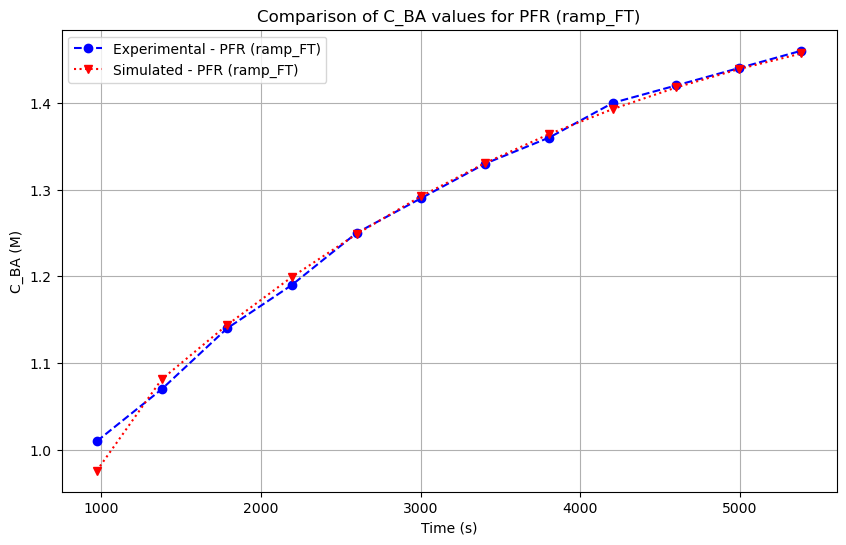

In [21]:
exp_num = 3  # choose a experiment number between 1 to 3. 
exp_name = data_i = {1: "ramp_F1", 2: "ramp_F2", 3: "ramp_FT"}
# ! Make sure you choose the same experiment number in the parmest section above as well. Otherwise, we will compare wrong experimental and simulated data.
data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}
T0_i = {1: 119, 2: 139.4, 3: 139.2}
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
# Let's combine all the estimated theta values and their SSE values in a dictionary for each experiment
theta_pfr = {
    1: {"KP1": 8.685554, "KP2": 4.112484, "SSE": 0.0002884404295743631},  # ramp_F1
    2: {"KP1": 8.017590, "KP2": 3.799587, "SSE": 0.0004594204929667396},  # ramp_F2
    3: {"KP1": 8.956306, "KP2": 7.619396, "SSE": 0.00029271643343941066}  # ramp_FT
}
BA_exp_sim = SimulateTransientPFR(
    data=data_i[exp_num],
    C_BA0=C_BA0_i[exp_num],
    v0=v0_i[exp_num],
    T0=T0_i[exp_num],
    alpha_v=alpha_v_i[exp_num],
    alpha_T=alpha_T_i[exp_num],
    theta= theta_pfr[exp_num],
    discr_method="dae.finite_difference",
    scheme="BACKWARD",
    nfe_t=100,
    nfe_z=50,
)
model_sim = (
    BA_exp_sim.get_labeled_model()
)  # get_labeled_model() takes the instance and build a model for the  instance
solved_model = BA_exp_sim.simulate(tee=True)  # we can now simulate the model

t_con = BA_exp_sim.t_control
# Extract C_BA values from solved model
CBA_sim = np.array(
    [solved_model.C_BA[t, 20].value for t in t_con]
) 

# Extracting time points
t_sim = t_con * 60  # min to sec, add 110 to start at t = 110 which I considered to be 0 in the model
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_sim, data_i[exp_num]["C_BA(M)"], "ob--", label=f"Experimental - PFR ({exp_name[exp_num]})")
ax.plot(t_sim, CBA_sim, "vr:", label=f"Simulated - PFR ({exp_name[exp_num]})")
ax.set_xlabel("Time (s)")
ax.set_ylabel("C_BA (M)")
ax.set_title(f"Comparison of C_BA values for PFR ({exp_name[exp_num]})")
ax.grid(which="both")
ax.legend()

### Multiple Experiment
Instead of estimating a parameter value for each of the parameters in each experiment, we will combine multiple experiments to estimate a single value for each of the parameters in parmest.

In [ ]:
exp_num = 2  # number of experiments to combine. 
# Choose ``2`` for combining two ramp_F experiments.
# Choose ``3`` for combining all the experiments.
data_m = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
C_BA0_m = {1: 1.56, 2: 1.55, 3: 1.56}
T0_m = {1: 119, 2: 139.4, 3: 139.2}
v0_m = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_m = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_m = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
theta_initial_m = {
    "KP1": 8.01758972730862,
    "KP2": 3.7995866696746776,
}  # theta value from ramp_F2 (using ``theta_ordered.to_dict()``). The parameter estimation is very senitive to this value.
exp_list_pfr = []
for i in range(1, exp_num + 1):
    exp_list_pfr.append(TransientPFR(
        data=data_m[i],
        C_BA0=C_BA0_m[i],
        v0=v0_m[i],
        T0=T0_m[i],
        alpha_v=alpha_v_m[i],
        alpha_T=alpha_T_m[i],
        theta_initial=  theta_initial_m,
        discr_method="dae.finite_difference",
        scheme="BACKWARD",
        nfe_t=200,
        nfe_z=50,
        t_skip=1
        ))
# BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
pest_m = parmest.Estimator(exp_list_pfr, obj_function='SSE', tee=True, solver_options={"linear_solver": "ma57", "max_iter": 100, "tol": 1e-5, })
obj_m, theta_m = pest_m.theta_est()

# printing model parameters
print("Model Parameters")
theta_ordered_m = theta_m.loc[['KP1', 'KP2']]
print("theta values: ")
print(theta_ordered_m)
print("\nSSE value: ", obj_m)

Ipopt 3.13.2: linear_solver=ma57
max_iter=100
tol=1e-05


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale s

#### Simulating with multiple experiment paramters

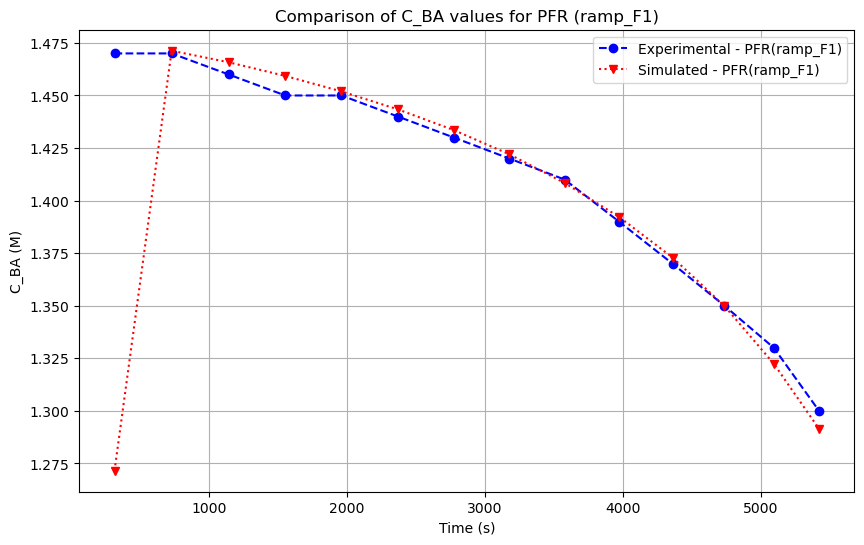

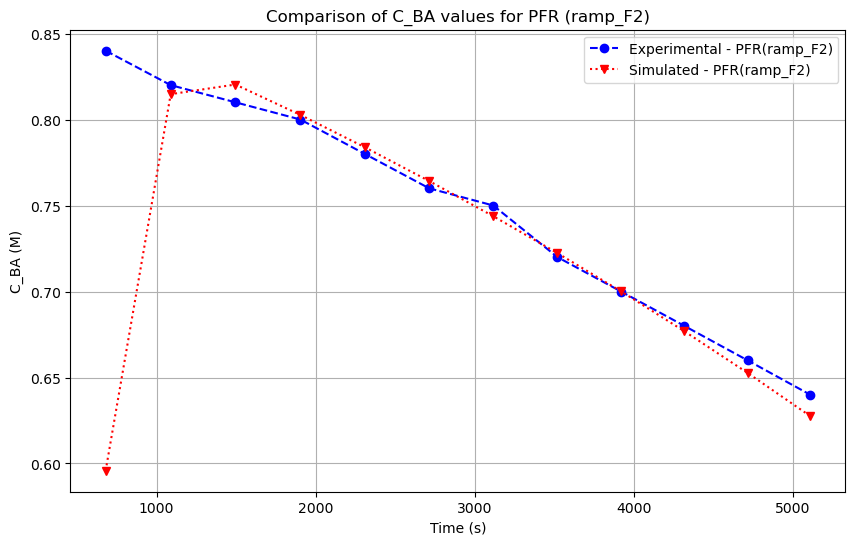

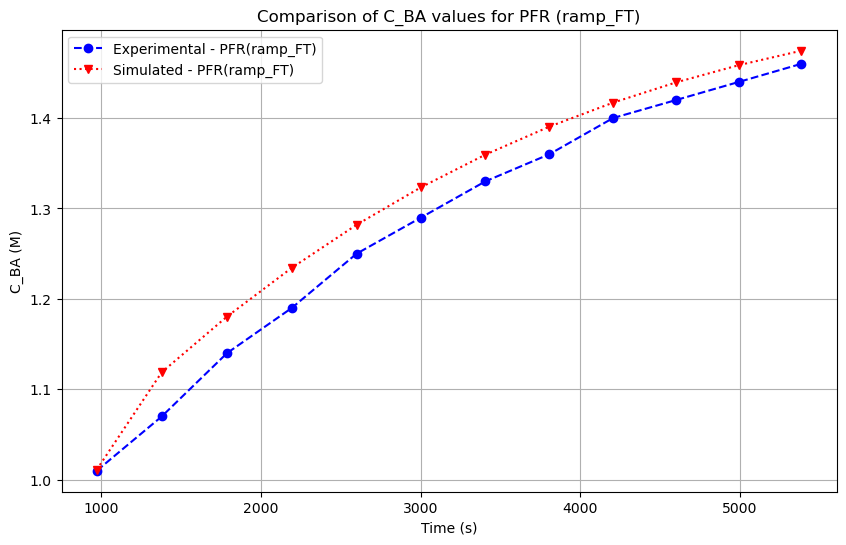

In [76]:
exp_name = data_i = {1: 'ramp_F1', 2: 'ramp_F2', 3: 'ramp_FT'}
data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}
T0_i = {1: 119, 2: 139.4, 3: 139.2}
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
theta_mul_exp = {1: {"KP1": 8.987939, "KP2": 7.464494, "SSE": 0.001570657722574639}}  # theta for the combined experiment
t_skip=0
for i in range(1, 4):
    BA_exp_sim = SimulateTransientPFR(
        data=data_i[i],
        C_BA0=C_BA0_i[i],
        v0=v0_i[i],
        T0=T0_i[i],
        alpha_v=alpha_v_i[i],
        alpha_T=alpha_T_i[i],
        theta=theta_ordered_m.to_dict(),
        discr_method="dae.finite_difference",
        scheme="BACKWARD",
        nfe_t=100,
        nfe_z=50,
        t_skip=t_skip
    )
    model_sim = (
        BA_exp_sim.get_labeled_model()
    )  # get_labeled_model() takes the instance and build a model for the  instance
    solved_model = BA_exp_sim.simulate(tee=False)  # we can now simulate the model

    # Extracting time points
    t_con = BA_exp_sim.t_control
    # Extract C_BA values from solved model
    CBA_sim = np.array([solved_model.C_BA[t, 20].value for t in t_con])

    t_sim = (
        t_con * 60
    )  # min to sec, add 110 to start at t = 110 which I considered to be 0 in the model
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        t_sim, data_i[i]["C_BA(M)"].iloc[t_skip:], "ob--", label=f"Experimental - PFR({exp_name[i]})"
    )
    ax.plot(t_sim, CBA_sim, "vr:", label=f"Simulated - PFR({exp_name[i]})")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("C_BA (M)")
    ax.set_title(f"Comparison of C_BA values for PFR ({exp_name[i]})")
    ax.grid()
    ax.legend()

## Shifted Time
Here, we will shift the time of the MBDOE problem by a certain amount of time (time the feed enters the reactor for the first time). This is not required, but I followed this procedure before I coded with the actual time data. So for reference, I will keep the code here, but I will commment it out so that it is not executed every time.
Uncomment the whole cell to run the code.

In [24]:
# class TransientPFR(Experiment):
#     def __init__(
#             self, 
#             data, 
#             C_BA0, 
#             v0, 
#             T0, 
#             alpha_v, 
#             alpha_T = 0, 
#             theta_initial = None,
#             discr_method = "dae.collocation",
#             scheme = None,
#             nfe_t = 50,
#             nfe_z = 50,
#             ncp = 3,
#             t_skip = 1
#             ):

#         '''
#         Parameters:
#             data: data of the experiment. dtype: pandas dataframe. 
#             C_BA0: initial concentration of benzoic acid, M
#             v0: initial flowrate, µL/min
#             T0: initial temperature, °C
#             alpha_v: flowrate ramping rate, µL/min^2
#             alpha_T: temperature ramping rate, °C/min^2
#             theta_initial: initial theta value, dimensionless
#             discr_method: discretization method, string. Options: "dae.collocation", "dae.finite_difference", "dae.finite_difference". default: "dae.collocation"
#             scheme: discretization scheme for "dae.finite_difference", string. Options: "BACKWARD", "FORWARD".
#             nfe_t: number of finite elements for time, integer. default: 50
#             nfe_z: number of finite elements for length, integer. default: 50
#             ncp: number of collocation points, integer. default: 3  
#             t_skip: time point to skip, integer. default: 1
#         '''
#         self.data = data
#         self.C_BA0 =  C_BA0
#         self.v0 = v0 * 1e-6  # µL/min to L/min
#         self.T0 = T0 + 273.15  # °C to K
#         self.alpha_v = alpha_v * 1e-6  # µL/min^2 to L/min^2
#         self.alpha_T = alpha_T
#         self.discr_method = discr_method
#         self.scheme = scheme
#         self.nfe_t = nfe_t
#         self.nfe_z = nfe_z
#         self.ncp = ncp
#         self.model = None
#         self.t_skip = t_skip

#         # Constants
#         self.AREA = 4.908738521234052e-06  # dm^2
#         self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
#         self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
#         self.SEC2MIN = 1 / 60  # second to minute conversion factor.
#         self.R = 8.314462618  # Universal gas constant, J/(mol-K)
#         self.TM = 378.15  # average temperature of the reactor, K
#         self.t_in = self.data.loc[0, 't_in(s)']  # sec, the time point the sample entered the PFR
#         self.t_control = (self.data.loc[self.t_skip:,'t_L(s)'] - self.t_in) * self.SEC2MIN  # min, the time points the sample left the PFR
#         """
#         we will ignore the first time point when the sample lefts the PFR. the PFR was initially empty, we should get a 
#         sharp discontinuous jump in concentration when C_BA goes from zero to some value. However, when solving pde, 
#         we won't get that sharp jump, it will be a smooth curve.For a sharp curve we need a step size of 0, or 
#         nfe= infinity. So, we will ignore the first time point, b/c the first point concentration will be much 
#         less than the actual conentration.  For the rest of the time points, we won't have this discontinuous
#         jump and the concentration will be smooth.
#         """
#         self.t_upper = self.t_control.max()  # min, upper bound of the ContinuousSet time

#         if theta_initial is None:
#             theta_initial = {'KP1': 9.12, 'KP2': 7.98}
#         self.theta_initial = theta_initial

#     def get_labeled_model(self):
#         if self.model is None:
#             self.create_model()
#             self.finalize_model()
#             self.label_experiment()
#         return self.model

#     # ============================================================================================================================
#     def create_model(self):
#         # model
#         m = self.model = pyo.ConcreteModel('Transient PFR model')

#         # continuous set
#         m.t = ContinuousSet(
#             bounds=(0, self.t_upper), 
#             initialize= self.t_control
#             )   # min
#         m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor, dm 
#         # we are not including the length of the pipe to the reactor and the pipe from the reactor to the detector.

#         # Define variables
#         m.C_BA = pyo.Var(m.t, m.z, initialize=self.C_BA0)  # benzoic acid concentration in M
#         m.T0 = pyo.Var(bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0)  # initial temperature, K
#         m.T = pyo.Var(m.t, initialize=self.T0)  # temperature, K
#         m.v0 = pyo.Var(bounds=(7.5e-6, 100e-6), initialize=self.v0)  # initial flowrate in L/min
#         m.v = pyo.Var(m.t, initialize= self.v0)  # flowrate in L/min

#         # Define derivative variables
#         m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
#         m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

#         # Define unknown parameters that need to be estimated
#         m.KP1 = pyo.Var(bounds = (0, 10))  # dimensionless
#         m.KP2 = pyo.Var(bounds = (0, 10))  # J/mol    

#         # Expressions
#         # equation for pre-exponential factor, k0
#         m.k0 = pyo.Expression(expr= pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM)))  # sec^(-1)
#         # equation for activation energy, EA
#         m.EA = pyo.Expression(expr= m.KP2 * 10000)  # J/mol
#         # equation for the Arrhenius equation
#         @m.Expression(m.t)   
#         def k(m, t):
#             return pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN   # min^(-1)

#         # Define the partial differential equations (PDE)
#         @m.Constraint(m.t, m.z)
#         def _pde_eqn(m, t, z):
#             if z==0:
#                 return pyo.Constraint.Skip
#             else:
#                 return m.dC_BA_dt[t, z] == - (m.v[t] / self.AREA) * m.dC_BA_dz[t, z] - m.k[t] * m.C_BA[t, z] 

#         # ramping the flowrate
#         @m.Constraint(m.t)
#         def flowrate_ramp(m, t):
#             return m.v[t] == m.v0 - self.alpha_v * (t + self.t_in * self.SEC2MIN) # L/min. 
#             # Note: only `self.t_in` is converted to min, b/c `m.t` is already in min.

#         # ramping the temperature
#         @m.Constraint(m.t)
#         def Temperature_ramp(m, t):
#             return m.T[t] == m.T0 - self.alpha_T * (t + self.t_in * self.SEC2MIN)  # K

#     # ============================================================================================================================
#     def finalize_model(self):
#         m = self.model

#         # fixing the unknown parameter values
#         m.KP1.fix(self.theta_initial['KP1'])
#         m.KP2.fix(self.theta_initial['KP2'])

#         # Boundary conditions
#         # @m.Constraint(m.t)
#         # def _inlet_conc(m, t):
#         #     return m.C_BA[t, 0] == m.C_BA0

#         # Discretizing the model
#         if self.discr_method == "dae.finite_difference":
#             pyo.TransformationFactory(self.discr_method).apply_to(m, nfe=self.nfe_t, scheme= self.scheme, wrt=m.t)  # discretize wrt time
#             pyo.TransformationFactory(self.discr_method).apply_to(m, nfe=self.nfe_z, scheme=self.scheme, wrt=m.z)  # discretize wrt length

#         elif self.discr_method == "dae.collocation":
#             pyo.TransformationFactory(self.discr_method).apply_to(m, nfe=self.nfe_t, ncp=self.ncp, wrt=m.t)  # discretize wrt time
#             pyo.TransformationFactory(self.discr_method).apply_to(m, nfe=self.nfe_z, ncp=self.ncp, wrt=m.z)  # discretize wrt length

#         else:
#             raise ValueError("Invalid discretization method. Options: 'dae.collocation', 'dae.finite_difference'")

#         # Let's define initial conditions for z>0
#         for z in m.z:
#             if z > 0:
#                 m.C_BA[0, z].fix(0)  

#         # Let's define initial conditions for z=0 / fixing the decision variable
#         for t in m.t:
#             m.C_BA[t, 0].fix(self.C_BA0)
#             # set upper limit and lower bounds for C_BA at reactor inlet
#             m.C_BA[t, 0].setlb(0.9)  # M
#             m.C_BA[t, 0].setub(1.56)  # M

#         # Fix the decision variables T0 and v0
#         m.T0.fix(self.T0)  # K
#         m.v0.fix(self.v0)  # L/min


#     # =================================================================================================================
#     def label_experiment(self):
#         m = self.model

#         # Experiment outputs
#         m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
#         m.experiment_outputs.update((m.C_BA[t, 20], self.data.loc[ind, 'C_BA(M)']) for ind, t in enumerate(self.t_control))

#         # Experiment inputs / control variables
#         m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
#         m.experiment_inputs.update((m.C_BA[t, 0], None) for t in self.t_control)  # we have already set the input as ``m.C_BA[t, 0].fix(self.C_BA0)``. 
#         # and we won't set it again. you can also set any value here instead of ``None``, and the result will be the same.
#         # So, it doesn't care about this value
#         # Note: if the decision variable is not a set, rather a scalar, then use the square bracket notation
#         # e.g. m.experiment_inputs.update([(m.C_BA[t, 0], None)]) . same applies for other experimental data, outputs etc
#         m.experiment_inputs[m.v0] = None
#         m.experiment_inputs[m.T0] = None

#         # Experimental measurement error
#         m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
#         m.measurement_error.update((m.C_BA[t, 20], self.BA_MEAS_ERR) for t in self.t_control)

#         # Unknown parameters
#         m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
#         m.unknown_parameters.update((k, pyo.value(k)) for k in [m.KP1, m.KP2])
#         # ============================================================================================

### Parmest - Shifted time
#### Single experiment
##### Finite difference method

In [25]:
# i = 0  # Choose an experiment number between 0 and 2. we could've made the follwing data a dict instead of a list.
# data_m = [ramp_F1, ramp_F2, ramp_FT]
# C_BA0_m = [1.56, 1.55, 1.56]  # M
# T0_m = [119, 139.4, 139.2]  # °C
# v0_m = [29.8, 9.13, 10.1]  # µL/min
# alpha_v_m = [0.253, 0.043, 0.05]  # µL/min^2
# alpha_T_m = [0, 0, 0.537]  # °C/min

# BA_exp = TransientPFR(
#         data=data_m[i], 
#         C_BA0=C_BA0_m[i], 
#         v0=v0_m[i], 
#         T0=T0_m[i], 
#         alpha_v=alpha_v_m[i], 
#         alpha_T=alpha_T_m[i],
#         discr_method = "dae.finite_difference",
#         scheme="BACKWARD",
#         nfe_t=100,
#         nfe_z=100
#         )

# # BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
# pest = parmest.Estimator([BA_exp], obj_function='SSE', tee=True, solver_options={"linear_solver": "ma57"})
# obj, theta = pest.theta_est()

# # printing model parameters
# print("Model Parameters")
# theta_ordered = theta.loc[['KP1', 'KP2']]
# print("theta values: ")
# print(theta_ordered)
# print("\nSSE value: ", obj)

##### Collocation

In [26]:
# i = 0  # Choose a experiment number between 0 and 2
# data_m = [ramp_F1, ramp_F2, ramp_FT]
# C_BA0_m = [1.56, 1.55, 1.56]  # M
# T0_m = [119, 139.4, 139.2]  # °C
# v0_m = [29.8, 9.13, 10.1]  # µL/min
# alpha_v_m = [0.253, 0.043, 0.05]  # µL/min^2
# alpha_T_m = [0, 0, 0.537]  # °C/min

# BA_exp = TransientPFR(
#         data=data_m[i], 
#         C_BA0=C_BA0_m[i], 
#         v0=v0_m[i], 
#         T0=T0_m[i], 
#         alpha_v=alpha_v_m[i], 
#         alpha_T=alpha_T_m[i],
#         discr_method="dae.collocation",
#         nfe_t=100,
#         nfe_z=100
#         )

# # BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
# pest = parmest.Estimator([BA_exp], obj_function='SSE', tee=True, solver_options={"linear_solver": "ma57"})
# obj, theta = pest.theta_est()

# # printing model parameters
# print("Model Parameters")
# theta_ordered = theta.loc[['KP1', 'KP2']]
# print("theta values: ")
# print(theta_ordered)
# print("\nSSE value: ", obj)

### Multiple experiments - PFR model

In [27]:
# data_m = [ramp_F1, ramp_F2, ramp_FT]
# exp_num = 2  # Choose a experiment number between 0 and 2 for which you want to run the model
# C_BA0_m = [1.56, 1.55, 1.56]  # M
# T0_m = [119, 139.4, 139.2]  # °C
# v0_m = [29.8, 9.13, 10.1]  # µL/min
# alpha_v_m = [0.253, 0.043, 0.05]  # µL/min^2
# alpha_T_m = [0, 0, 0.537]  # °C/min

# exp_list_pfr = []
# for i in range(3):
#     exp_list_pfr.append(TransientPFR(
#         data=data_m[i], 
#         C_BA0=C_BA0_m[i], 
#         v0=v0_m[i], 
#         T0=T0_m[i], 
#         alpha_v=alpha_v_m[i], 
#         alpha_T=alpha_T_m[i],
#         discr_method="dae.finite_difference",
#         scheme="BACKWARD",
#         nfe_t=20,
#         nfe_z=100
#         ))
# # BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
# pest_m = parmest.Estimator(exp_list_pfr, obj_function='SSE', tee=False, solver_options={"linear_solver": "ma57", "max_iter": 100, "tol": 1e-5, })
# obj_m, theta_m = pest_m.theta_est()

# # printing model parameters
# print("Model Parameters")
# theta_ordered_m = theta_m.loc[['KP1', 'KP2']]
# print("theta values: ")
# print(theta_ordered_m)
# print("\nSSE value: ", obj_m)

### Checking the parameter dependency on initial guess of theta

In [28]:
# data = ramp_F1
# for i in range(1, 11):
#     theta_init = {"KP1":11-i, "KP2": i}
#     BA_exp = TransientPFR(data=data, C_BA0=1.56, v0=29.8, T0=119, alpha_v=0.253, theta_initial=theta_init)
#     pest = parmest.Estimator([BA_exp], obj_function='SSE', tee=False, solver_options={"linear_solver": "ma57"})
#     obj, theta = pest.theta_est()
#     print("\n--------------------------XXX--------------------------")
#     print("Model Parameters")
#     theta_ordered = theta.loc[['KP1', 'KP2']]
#     print("theta values: ")
#     print(theta_ordered)
#     print("\nSSE value: ", obj)

The theta value is not dependent on the initial guess in the range of theta(1, 11)

### Simulating the model from the parameters estimated from parmest
At first, we will modify the class and remove the `finialize_model()` method as we will not be using it. 

In [29]:
# class SimulateTransientPFR(Experiment):
#     def __init__(
#             self, 
#             data, 
#             C_BA0, 
#             v0, 
#             T0, 
#             alpha_v, 
#             alpha_T = 0, 
#             theta_initial = theta_ordered.to_dict(),
#             discr_method = "dae.finite_difference",
#             scheme = "BACKWARD",
#             nfe_t = 50,
#             nfe_z = 50,
#             ncp = None
#             ):
        
#         '''
#         Parameters:
#             data: data of the experiment. dtype: pandas dataframe. 
#             C_BA0: initial concentration of benzoic acid, M
#             v0: initial flowrate, µL/min
#             T0: initial temperature, °C
#             alpha_v: flowrate ramping rate, µL/min^2
#             alpha_T: temperature ramping rate, °C/min^2
#             theta_initial: initial theta value. default: theta_ordered.to_dict(), the value estimated from the parmest
#             discr_method: discretization method, string. Options: "dae.collocation", "dae.finite_difference", "dae.finite_difference". default: "dae.finite_difference"
#             scheme: discretization scheme for "dae.finite_difference", string. Options: "BACKWARD", "FORWARD". default: "BACKWARD"
#             nfe_t: number of finite elements for time, integer. default: 50
#             nfe_z: number of finite elements for length, integer. default: 50
#             ncp: number of collocation points, integer. default: None     
#         '''
#         self.data = data
#         self.C_BA0 =  C_BA0
#         self.v0 = v0 * 1e-6  # µL/min to L/min
#         self.T0 = T0 + 273.15  # °C to K
#         self.alpha_v = alpha_v * 1e-6  # µL/min^2 to L/min^2
#         self.alpha_T = alpha_T
#         self.discr_method = discr_method
#         self.scheme = scheme
#         self.nfe_t = nfe_t
#         self.nfe_z = nfe_z
#         self.ncp = ncp
#         self.model = None

#         # Constants
#         self.AREA = 4.908738521234052e-06  # dm^2
#         self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
#         self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
#         self.SEC2MIN = 1 / 60  # second to minute conversion factor.
#         self.R = 8.314462618  # Universal gas constant, J/(mol-K)
#         self.TM = 378.15  # average temperature of the reactor, K
#         self.t_in = self.data.loc[0, 't_in(s)']  # sec, the time point the sample entered the PFR
#         self.t_control = (self.data.loc[1:, 't_L(s)'] - self.t_in) * self.SEC2MIN  # min, the time points the sample left the PFR
#         self.t_upper = self.t_control.max()  # min, upper bound of the ContinuousSet time
        
#         self.theta_initial = theta_initial


#     def get_labeled_model(self):
#         if self.model is None:
#             self.create_model()
#             self.finalize_model()
#         return self.model


#     #============================================================================================================================
#     def create_model(self):
#         # model
#         m = self.model = pyo.ConcreteModel('Transient PFR model')

#         # continuous set
#         m.t = ContinuousSet(
#             bounds=(0, self.t_upper), 
#             initialize= self.t_control
#             )
#         m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor, dm 
#         # we are not including the length of the pipe to the reactor and the pipe from the reactor to the detector.

#         # define variables
#         m.C_BA = pyo.Var(m.t, m.z, initialize=0.5)  # benzoic acid concentration in M
#         m.T0 = pyo.Var(bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0)  # initial temperature, K
#         m.T = pyo.Var(m.t, initialize=self.T0)  # temperature, K
#         m.v0 = pyo.Var(bounds=(7.5e-6, 100e-6), initialize=self.v0)  # flowrate in L/min
#         m.v = pyo.Var(m.t, initialize= self.v0 )  # flowrate in L/min

#         # Define derivative variables
#         m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
#         m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)


#         # Define unknown parameters that need to be estimated
#         m.KP1 = pyo.Var(bounds = (0, 10))  # dimensionless
#         m.KP2 = pyo.Var(bounds = (0, 10))  # J/mol    
        

#         # Expressions
#         # equation for pre-exponential factor, k0
#         m.k0 = pyo.Expression(expr= pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM)))
#         # equation for activation energy, EA
#         m.EA = pyo.Expression(expr= m.KP2 * 10000)
#         # equation for the Arrhenius equation 
#         @m.Expression(m.t)   
#         def k(m, t):
#             return pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN

#         # Define the partial differential equations (PDE)
#         @m.Constraint(m.t, m.z)
#         def _pde_eqn(m, t, z):
#             if z==0:
#                 return pyo.Constraint.Skip
#             else:
#                 return m.dC_BA_dt[t, z] == - (m.v[t] / self.AREA) * m.dC_BA_dz[t, z] - m.k[t] * m.C_BA[t, z] 

#         # ramping the flowrate
#         @m.Constraint(m.t)
#         def flowrate_ramp(m, t):
#             return m.v[t] == m.v0 - self.alpha_v * (t + self.t_in * self.SEC2MIN)  # L/min

#         # ramping the temperature
#         @m.Constraint(m.t)
#         def Temperature_ramp(m, t):
#             return m.T[t] == m.T0 - self.alpha_T * (t + self.t_in * self.SEC2MIN)  # K

    
#     #============================================================================================================================
#     def finalize_model(self):
#         m = self.model

#         # fixing the unknown parameter values
#         m.KP1.fix(self.theta_initial['KP1'])
#         m.KP2.fix(self.theta_initial['KP2'])

#         # Boundary conditions
#         # @m.Constraint(m.t)
#         # def _inlet_conc(m, t):
#         #     return m.C_BA[t, 0] == m.C_BA0


#         # Discretizing the model
#         if self.discr_method == "dae.finite_difference":
#             pyo.TransformationFactory(self.discr_method).apply_to(m, nfe=self.nfe_t, scheme= self.scheme, wrt=m.t)  # discretize wrt time
#             pyo.TransformationFactory(self.discr_method).apply_to(m, nfe=self.nfe_z, scheme=self.scheme, wrt=m.z)  # discretize wrt length

#         elif self.discr_method == "dae.collocation":
#             pyo.TransformationFactory(self.discr_method).apply_to(m, nfe=self.nfe_t, ncp=self.ncp, wrt=m.t)  # discretize wrt time
#             pyo.TransformationFactory(self.discr_method).apply_to(m, nfe=self.nfe_z, ncp=self.ncp, wrt=m.z)  # discretize wrt length

#         else:
#             raise ValueError("Invalid discretization method. Options: 'dae.collocation', 'dae.finite_difference'")

        
#         # Let's define initial conditions for z>0
#         for z in m.z:
#             if z > 0:
#                 m.C_BA[0, z].fix(0)   # ?m.t.first()??
        
#         # Let's define initial conditions for z=0 / fixing the decision variable
#         for t in m.t:
#             m.C_BA[t, 0].fix(self.C_BA0)
#             # set upper limit and lower bounds for C_BA at reactor inlet
#             m.C_BA[t, 0].setlb(0.9)  # M
#             m.C_BA[t, 0].setub(1.56)  # M

#         # Fix the decision variables T0 and v0
#         m.T0.fix(self.T0)  # K
#         m.v0.fix(self.v0)  # L/min

#     def simulate(self, tee=True):
#         model = self.model
#         solver = pyo.SolverFactory('ipopt')
#         solver.solve(model, tee=tee) 
#         return model  

Let's solve the model and then simulate the results.

In [30]:
# data = ramp_F1
# BA_exp_sim = SimulateTransientPFR(
#     data=data, 
#     C_BA0=1.56, 
#     v0=29.8, 
#     T0=119, 
#     alpha_v=0.253, 
#     discr_method="dae.finite_difference",
#     scheme='BACKWARD',
#     nfe_t=200,
#     nfe_z=50,
#     )
# model_sim = BA_exp_sim.get_labeled_model()  # get_labeled_model() takes the instance and build a model for the  instance
# solved_model = BA_exp_sim.simulate(tee=True)  # we can now simulate the 

# t_con = BA_exp_sim.t_control 
# # Extract C_BA values from solved model
# CBA_sim = np.array([solved_model.C_BA[t, 20].value for t in t_con])  # ignore first time point (transient), since there is no C_BA out at t = 110

# # Extracting time points
# t_solved = np.array(solved_model.t)  # N_t time points
# t_sim = t_con*60+110  # min to sec, add 110 to start at t = 110 which I considered to be 0 in the model
# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(t_sim, CBA_sim, "o"  , label="Simulated - PFR")
# ax.plot(ramp_F1["t_L(s)"], ramp_F1["C_BA(M)"], "x", label="Experimental - PFR")
# ax.set_xlabel("Time (s)")
# ax.set_ylabel("C_BA (M)")
# ax.set_title("Comparison of C_BA values for PFR")
# ax.grid(which="both")
# ax.legend()

Extract data from the solved model and plot the results.

### Accesssing the model from instance level

In [31]:
# # access the model from the BA_exp object
# model = BA_exp.model
# # pprint the model
# model.pprint()

### Calculate rate constant

In [32]:
# def k0_k_EA(T, KP1, KP2):
#     return (
#         np.exp(-KP1 + (KP2 * 1e4) / (8.314462618 * 378.15)) , 
#         np.exp(-KP1 - (KP2 * 1e4 / 8.314462618) * (1 / T - 1 / 378.15)), #* 60  # min^-1
#         KP2 * 1e4
#     )


# k0, k, Ea = k0_k_EA(100+273.15, 9.12, 7.98)
# print("k0 = %0.3e per sec" %k0)
# print("k = %0.3e per sec" %k)
# print("EA = %0.3e J/mol" %Ea)

# ODE Class
## Ramp F
Here, we will approximate the PFR as a batch reactor

In [33]:
class PFRasBatch(Experiment):
    def __init__(self, data, theta_initial=None, C_BA0=1.56, T0=119, t_skip=1):
        '''
        Parameters:
            data: data of the experiment. dtype: pandas dataframe. 
            theta_initial: initial values of the unknown parameters. dtype: dictionary.
            C_BA0: initial concentration of benzoic acid, M, default: 1.56 M
            T0: initial temperature, °C. default: 119 °C.
        '''
        self.data = data
        self.C_BA0 =  C_BA0
        self.T0 = T0 + 273.15  # °C to K
        self.model = None
        self.t_skip = t_skip

        # Constants
        self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
        self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
        self.SEC2MIN = 1 / 60  # second to minute conversion factor.
        self.R = 8.314462618  # Universal gas constant, J/(mol-K)
        self.TM = 378.15  # average temperature of the reactor, K
        self.nfe = 200  # number of finite elements for the discretization
         
        self.t_control = self.data.loc[self.t_skip:, "tau(s)"] * self.SEC2MIN  # min, residence time of the batch reactor
        self.t_upper = self.t_control.max()  # min, upper bound of the ContinuousSet time

        self.theta_initial = theta_initial  # initial values of the unknown parameters

        if self.theta_initial is None:
            self.theta_initial = {'KP1': 10, 'KP2': 10}


    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
            self.label_experiment()
        return self.model


    #============================================================================================================================
    def create_model(self):
        # model
        m = self.model = pyo.ConcreteModel('Batch assumption model')

        # continuous set
        m.t = ContinuousSet(
            bounds=(0, self.t_upper), 
            initialize= self.t_control
            )

        # define variables
        m.C_BA = pyo.Var(m.t, bounds=(0, 10), initialize=self.C_BA0)  # benzoic acid concentration in M
        m.T0 = pyo.Var(bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0)  # initial temperature, K
        m.T = pyo.Var(m.t, initialize=self.T0)  # temperature in °C
        
        # Define derivative variables
        m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)


        # Define unknown parameters that need to be estimated
        m.KP1 = pyo.Var(bounds = (0, 10))  # dimensionless
        m.KP2 = pyo.Var(bounds = (0, 10))  # J/mol   

        # Expressions
        # equation for pre-exponential factor, k0
        m.k0 = pyo.Expression(expr= pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM)))
        # equation for activation energy, EA
        m.EA = pyo.Expression(expr= m.KP2 * 10000)
        # equation for the Arrhenius equation 

        @m.Expression(m.t)   
        def k(m, t):
            return pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN 
        """
        m.k = pyo.Var(m.t, initialize=1)
        @m.Constraint(m.t)
        def _rate_constant(m, t):
            return m.k[t] == pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN
        # `Constraint` and `Expression` both give the same result in `Parmest`.
        """
        # Define the ODE
        @m.Constraint(m.t)
        def _ode_eqn(m, t):
            return m.dC_BA_dt[t] == - m.k[t] * m.C_BA[t] 

        
    #============================================================================================================================
    def finalize_model(self):
        m = self.model

        # fixing the unknown parameter values
        m.KP1.fix(self.theta_initial['KP1'])
        m.KP2.fix(self.theta_initial['KP2'])

        # Boundary conditions
        # @m.Constraint(m.t)
        # def _inlet_conc(m, t):
        #     return m.C_BA[t, 0] == m.C_BA0


        # Discretizing the model
        pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=self.nfe, scheme="BACKWARD", wrt=m.t)  # discretize wrt time
        
        # Fix the decision variables
        m.C_BA[0].fix(self.C_BA0)
        m.T0.fix(self.T0)  # K

        # Let's fix the temperature
        for t in m.t:
            m.T[t].fix(self.T0)

     #=================================================================================================================       
    def label_experiment(self):
        m = self.model

        # Experiment outputs
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update((m.C_BA[t], self.data.loc[(ind+self.t_skip), 'C_BA(M)']) for ind, t in enumerate(self.t_control))

        # Experiment inputs / control variables
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs[m.C_BA[0]] = None  # we have already set the input as ``m.G1[0].fix(100)``. 
        # and we won't set it again. you can also set any value here instead of ``None``, and the result will be the same. 
        # So, it doesn't care about this value
        m.experiment_inputs.update((m.T[t], None) for t in self.t_control)
        

        # Experimental measurement error
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update((m.C_BA[t], self.BA_MEAS_ERR) for t in self.t_control)

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update((k, pyo.value(k)) for k in [m.KP1, m.KP2])
        #============================================================================================

### Parmest
#### Single experiment

In [34]:
# Choose any value of i from 0 to 1. For ramp_FT case, we need to change the model a bit
i = 1
data_i = [ramp_F1, ramp_F2, ramp_FT]
C_BA0_i = [1.56, 1.55, 1.56]
T0_i = [119, 139.4, 139.2]
BA_exp_batch = PFRasBatch(data=data_i[i], C_BA0=C_BA0_i[i], T0=T0_i[i])
pest = parmest.Estimator([BA_exp_batch], obj_function='SSE', tee=True, solver_options={"linear_solver": "ma57"})
obj_bat, theta_bat= pest.theta_est()

# printing model parameters
# print("\n--------------------------XXX--------------------------")
print("Model Parameters")
theta_bat = theta_bat.loc[['KP1', 'KP2']]
print("theta values: ")
print(theta_bat)
print("\nSSE value: ", obj_bat)

Ipopt 3.13.2: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        compu

#### Multiple experiment

In [35]:
data_m = [ramp_F1, ramp_F2]
C_BA0_m = [1.56, 1.55]
T0_m = [119, 139.4]
exp_list = []
for i in range(2):
    exp_list.append(PFRasBatch(data=data_m[i], C_BA0=C_BA0_m[i], T0=T0_m[i]))


pest_m = parmest.Estimator(exp_list, obj_function='SSE', tee=False, solver_options={"linear_solver": "ma57"})
obj_bat_m, theta_bat_m= pest_m.theta_est()

# printing model parameters
print("\n--------------------------XXX--------------------------")
print("Model Parameters")
theta_bat_m = theta_bat_m.loc[['KP1', 'KP2']]
print("theta values: ")
print(theta_bat_m)
print("\nSSE value: ", obj_bat_m)


--------------------------XXX--------------------------
Model Parameters
theta values: 
KP1    9.122588
KP2    7.953814
dtype: float64

SSE value:  0.0005477334132317052


### Class - Simulation

In [36]:
class PFRasBatchSim(Experiment):
    def __init__(self, data, theta_initial=None, C_BA0=1.56, T0=119):
        '''
        Parameters:
            data: data of the experiment. dtype: pandas dataframe. 
            C_BA0: initial concentration of benzoic acid, M, default: 1.56 M
            T0: initial temperature, °C. default: 119 °C.
        '''
        self.data = data
        self.C_BA0 =  C_BA0
        self.T0 = T0 + 273.15  # °C to K
        self.model = None

        # Constants
        self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
        self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
        self.SEC2MIN = 1 / 60  # second to minute conversion factor.
        self.R = 8.314462618  # Universal gas constant, J/(mol-K)
        self.TM = 378.15  # average temperature of the reactor, K
        self.nfe = len(self.data["tau(s)"])  # number of finite elements for the discretization
         
        # self.theta_initial = {'KP1': 8.847856, 'KP2': 3.973650}  # parameter values from pde
        # self.theta_initial = {'KP1': 8.591468, 'KP2': 3.369068}  # parameter values from ode
        self.theta_initial = theta_initial  # initial values of the unknown parameters
        if self.theta_initial is None:
            self.theta_initial = {'KP1': 8.602782, 'KP2': 3.525046}
            
        self.t_control = self.data["tau(s)"] * self.SEC2MIN  # min, residence time of the batch reactor
        self.t_upper = self.t_control.max()  # min, upper bound of the ContinuousSet time


    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
        return self.model


    #============================================================================================================================
    def create_model(self):
        # model
        m = self.model = pyo.ConcreteModel('Batch assumption model')

        # continuous set
        m.t = ContinuousSet(
            bounds=(0, self.t_upper), 
            initialize= self.t_control
            )

        # define variables
        m.C_BA = pyo.Var(m.t, initialize=self.C_BA0)  # benzoic acid concentration in M
        m.T0 = pyo.Var(bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0)  # initial temperature, K
        m.T = pyo.Var(m.t, initialize=self.T0)  # temperature in °C
        
        # Define derivative variables
        m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)


        # Define unknown parameters that need to be estimated
        m.KP1 = pyo.Var(bounds = (0, 10))  # dimensionless
        m.KP2 = pyo.Var(bounds = (0, 10))  # J/mol   

        # Expressions
        # equation for pre-exponential factor, k0
        m.k0 = pyo.Expression(expr= pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM)))
        # equation for activation energy, EA
        m.EA = pyo.Expression(expr= m.KP2 * 10000)
        # equation for the Arrhenius equation 

        @m.Expression(m.t)   
        def k(m, t):
            return pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN 
        """
        m.k = pyo.Var(m.t, initialize=1)
        @m.Constraint(m.t)   
        def _rate_constant(m, t):
            return m.k[t] == pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN
        # `Constraint` and `Expression` both give the same result in `Parmest`.
        """
        # Define the ODE
        @m.Constraint(m.t)
        def _ode_eqn(m, t):
            return m.dC_BA_dt[t] == - m.k[t] * m.C_BA[t] 

      #============================================================================================================================
    def finalize_model(self):
        m = self.model

        # fixing the unknown parameter values
        m.KP1.fix(self.theta_initial['KP1'])
        m.KP2.fix(self.theta_initial['KP2'])

        # Boundary conditions
        # @m.Constraint(m.t)
        # def _inlet_conc(m, t):
        #     return m.C_BA[t, 0] == m.C_BA0


        # Discretizing the model
        pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=self.nfe, scheme="BACKWARD", wrt=m.t)  # discretize wrt time
        
        # Fix the decision variables
        m.C_BA[0].fix(self.C_BA0)
        m.T0.fix(self.T0)  # K

        # Let's fix the temperature
        for t in m.t:
            m.T[t].fix(self.T0)

    def simulate(self, tee=True):
        model = self.model
        solver = pyo.SolverFactory('ipopt')
        res = solver.solve(model, tee=tee) 
        return model  

#### Model Simulation

In [37]:
data = ramp_F1
BA_exp_bat_sim = PFRasBatchSim(data=data, theta_initial=theta_bat_m, C_BA0=1.56, T0=119)
model_bat_sim = BA_exp_bat_sim.get_labeled_model()  # get_labeled_model() ensures that the model is built and labeled with the correct variables
solved_model_bat = BA_exp_bat_sim.simulate(tee=True)  # apply the `simulate()` method on instance
# So we need to apply the `simulate()` method on the instance of `PFRasBatchSim` class to get the solved model.
# not on the `model_bat_sim` object, which returns the concrete model

# Extract C_BA values from solved model
CBA_bat = np.array([solved_model_bat.C_BA[t]() for t in solved_model_bat.t])
CBA_bat_sim = CBA_bat[1:]
CBA_bat_sim

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

array([1.47874312, 1.47358305, 1.46804693, 1.46135515, 1.45391418,
       1.4457362 , 1.43568151, 1.42417295, 1.4104953 , 1.39471655,
       1.37545081, 1.35249912, 1.3253668 , 1.29501862])

#### Plotting the simulated and experimental data

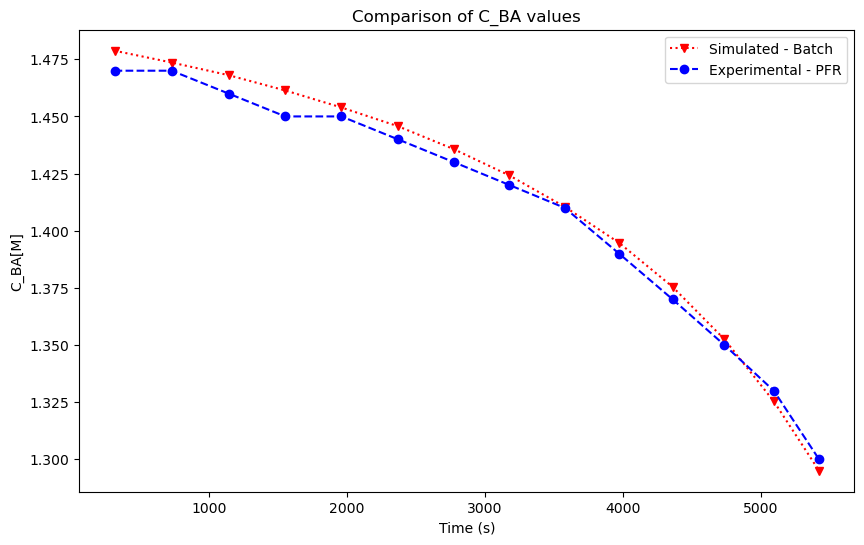

In [38]:
# PFR DATA
# Extracting time points
t_solved = np.array(solved_model_bat.t)  # N_t time points
t_sim = t_solved*60+110  # min to sec, add 110 to start at t = 110 which I considered to be 0 in the model
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(ramp_F1["t_L(s)"], CBA_sim, "gv-"  , label="Simulated - PFR")


# BATCH DATA
ax.plot(ramp_F1["t_L(s)"], CBA_bat_sim, "rv:", label="Simulated - Batch") 

# Experimental Data
ax.plot(ramp_F1["t_L(s)"], ramp_F1["C_BA(M)"], "bo--", label="Experimental - PFR")

# Setting labels and title
ax.set_xlabel("Time (s)")
ax.set_ylabel("C_BA[M]")
ax.set_title("Comparison of C_BA values")
ax.legend()

In [39]:
# pprint
# m_b = BA_exp_batch.model  # self.model
# m_b.pprint()

## Ramp FT
Here, both flowrate and temperature are varied in a ramp fashion. In this case, we have to consider each sample time as a seprate batch reaction. so the overall experiment will be considereda as a collection of batch reactions.

In [40]:
class PFRasBatchFT(Experiment):
    def __init__(self, data, theta_initial=None, C_BA0=1.56, alpha_T = 0.537, nfe=10):
        '''
        Parameters:
            data: data of the experiment. dtype: pandas dataframe. 
            theta_initial: initial values of the unknown parameters. dtype: dictionary.
            C_BA0: initial concentration of benzoic acid, M, default: 1.56 M
            T0: initial temperature, °C. default: 119 °C.
            alpha_T: temperature rampt rate, °C/min. default: 0.537 °C/min.
            nfe: number of finite elements. default: 10.
        '''
        self.data = data
        self.C_BA0 =  C_BA0
        self.alpha_T = alpha_T  # °C/min
        self.model = None

        # Constants
        self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
        self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
        self.SEC2MIN = 1 / 60  # second to minute conversion factor.
        self.R = 8.314462618  # Universal gas constant, J/(mol-K)
        self.TM = 378.15  # average temperature of the reactor, K
        self.nfe = nfe  # number of finite elements for the discretization
         
        self.t_control = self.data["tau(s)"] * self.SEC2MIN  # min, residence time of the batch reactor
        self.t_upper = self.t_control  # min, upper bound of the ContinuousSet time

        self.theta_initial = theta_initial  # initial values of the unknown parameters

        if self.theta_initial is None:
            self.theta_initial = {'KP1': 9.12, 'KP2': 7.98}  # initial values from Waldron et al. paper


    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
            self.label_experiment()
        return self.model


    #============================================================================================================================
    def create_model(self):
        # model
        m = self.model = pyo.ConcreteModel('Batch assumption model - FT')

        # continuous set
        m.t = ContinuousSet(bounds=(0, self.t_upper))  # min

        # define variables
        m.C_BA = pyo.Var(m.t, bounds=(0, 10), initialize=self.C_BA0)  # benzoic acid concentration in M
        m.T0 = pyo.Var(bounds=((70 + 273.15), (140 + 273.15)), initialize=(self.data["T_in(C)"]+273.15))  # initial temperature, K
        m.T = pyo.Var(m.t, initialize=(self.data["T_in(C)"]+273.15))  # temperature in °C
        
        # Define derivative variables
        m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)


        # Define unknown parameters that need to be estimated
        m.KP1 = pyo.Var(bounds = (0, 10))  # dimensionless
        m.KP2 = pyo.Var(bounds = (0, 10))  # J/mol   

        # Expressions
        # equation for pre-exponential factor, k0
        m.k0 = pyo.Expression(expr= pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM)))
        # equation for activation energy, EA
        m.EA = pyo.Expression(expr= m.KP2 * 10000)
        # equation for the Arrhenius equation

        @m.Expression(m.t)   
        def k(m, t):
            return pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN 
        """
        m.k = pyo.Var(m.t, initialize=1)
        @m.Constraint(m.t)
        def _rate_constant(m, t):
            return m.k[t] == pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN
        # `Constraint` and `Expression` both give the same result in `Parmest`. I have checked with both of them.
        """
        # Define the ODE
        @m.Constraint(m.t)
        def _ode_eqn(m, t):
            return m.dC_BA_dt[t] == - m.k[t] * m.C_BA[t] 

        # ramping the temperature
        @m.Constraint(m.t)
        def Temperature_ramp(m, t):
            return m.T[t] == m.T0 - self.alpha_T * t   # K


        
    #============================================================================================================================
    def finalize_model(self):
        m = self.model

        # fixing the unknown parameter values
        m.KP1.fix(self.theta_initial['KP1'])
        m.KP2.fix(self.theta_initial['KP2'])

    
        # Discretizing the model
        pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=self.nfe, scheme="BACKWARD", wrt=m.t)  # discretize wrt time
        
        # Fix the decision variables
        m.C_BA[0].fix(self.C_BA0)
        m.T0.fix(self.data["T_in(C)"]+273.15)  # K

        '''
        # Let's fix the temperature
        for t in m.t:
            m.T[t].fix(self.T0)
        '''

     #=================================================================================================================       
    def label_experiment(self):
        m = self.model

        # Experiment outputs
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update([(m.C_BA[self.t_control], self.data['C_BA(M)'])])

        # Experiment inputs / control variables
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs[m.C_BA[0]] = None  # we have already set the input as ``m.G1[0].fix(100)``. 
        # and we won't set it again. you can also set any value here instead of ``None``, and the result will be the same. 
        # So, it doesn't care about this value
        m.experiment_inputs.update([(m.T0, None)])
        

        # Experimental measurement error
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update((m.C_BA[ind], self.BA_MEAS_ERR) for ind in [0, self.t_control])

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update((k, pyo.value(k)) for k in [m.KP1, m.KP2])
        #============================================================================================

### Parmest

In [41]:
num_exp = len(ramp_FT)  # number of experiments
exp_list_FT = []
for i in range(num_exp):
    exp_list_FT.append(PFRasBatchFT(data=ramp_FT.iloc[i]))   

pest_FT = parmest.Estimator(exp_list_FT, obj_function='SSE', tee=False, solver_options={"linear_solver": "ma57"})
obj_bat_FT, theta_bat_FT= pest_FT.theta_est()

# printing model parameters
print("\n--------------------------XXX--------------------------")
print("Model Parameters")
theta_bat_FT = theta_bat_FT.loc[['KP1', 'KP2']]
print("theta values: ")
print(theta_bat_FT)
print("\nSSE value: ", obj_bat_FT)


--------------------------XXX--------------------------
Model Parameters
theta values: 
KP1    8.929774
KP2    7.760707
dtype: float64

SSE value:  1.082038404897147e-05


### Simulating the FT model

In [42]:
class BatchSimulateFT(Experiment):
    def __init__(self, data, theta_initial=theta_bat_FT.to_dict(), C_BA0=1.56, alpha_T = 0.537):
        '''
        Parameters:
            data: data of the experiment. dtype: pandas dataframe. 
            theta_initial: initial values of the unknown parameters. dtype: dictionary.
            C_BA0: initial concentration of benzoic acid, M, default: 1.56 M
            T0: initial temperature, °C. default: 119 °C.
            alpha_T: temperature rampt rate, °C/min. default: 0.537 °C/min.
        '''
        self.data = data
        self.C_BA0 =  C_BA0
        self.alpha_T = alpha_T  # °C/min
        self.model = None

        # Constants
        self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
        self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
        self.SEC2MIN = 1 / 60  # second to minute conversion factor.
        self.R = 8.314462618  # Universal gas constant, J/(mol-K)
        self.TM = 378.15  # average temperature of the reactor, K
        self.nfe = 10  # number of finite elements for the discretization
         
        self.t_control = self.data["tau(s)"] * self.SEC2MIN  # min, residence time of the batch reactor
        self.t_upper = self.t_control  # min, upper bound of the ContinuousSet time

        self.theta_initial = theta_initial  # initial values of the unknown parameters

        if self.theta_initial is None:
            self.theta_initial = {'KP1': 9.12, 'KP2': 7.98}  # initial values from Waldron et al. paper


    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
        return self.model


    #============================================================================================================================
    def create_model(self):
        # model
        m = self.model = pyo.ConcreteModel('Batch assumption model - FT')

        # continuous set
        m.t = ContinuousSet(bounds=(0, self.t_upper))  # min

        # define variables
        m.C_BA = pyo.Var(m.t, bounds=(0, 10), initialize=self.C_BA0)  # benzoic acid concentration in M
        m.T0 = pyo.Var(bounds=((70 + 273.15), (140 + 273.15)), initialize=(self.data["T_in(C)"]+273.15))  # initial temperature, K
        m.T = pyo.Var(m.t, initialize=(self.data["T_in(C)"]+273.15))  # temperature in °C
        
        # Define derivative variables
        m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)


        # Define unknown parameters that need to be estimated
        m.KP1 = pyo.Var(bounds = (0, 10))  # dimensionless
        m.KP2 = pyo.Var(bounds = (0, 10))  # J/mol   

        # Expressions
        # equation for pre-exponential factor, k0
        m.k0 = pyo.Expression(expr= pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM)))
        # equation for activation energy, EA
        m.EA = pyo.Expression(expr= m.KP2 * 10000)
        # equation for the Arrhenius equation

        @m.Expression(m.t)   
        def k(m, t):
            return pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN 
        """
        m.k = pyo.Var(m.t, initialize=1)
        @m.Constraint(m.t)
        def _rate_constant(m, t):
            return m.k[t] == pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM)) / self.SEC2MIN
        # `Constraint` and `Expression` both give the same result in `Parmest`. I have checked with both of them.
        """
        # Define the ODE
        @m.Constraint(m.t)
        def _ode_eqn(m, t):
            return m.dC_BA_dt[t] == - m.k[t] * m.C_BA[t] 

        # ramping the temperature
        @m.Constraint(m.t)
        def Temperature_ramp(m, t):
            return m.T[t] == m.T0 - self.alpha_T * t   # K


        
    #============================================================================================================================
    def finalize_model(self):
        m = self.model

        # fixing the unknown parameter values
        m.KP1.fix(self.theta_initial['KP1'])
        m.KP2.fix(self.theta_initial['KP2'])

    
        # Discretizing the model
        pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=self.nfe, scheme="BACKWARD", wrt=m.t)  # discretize wrt time
        
        # Fix the decision variables
        m.C_BA[0].fix(self.C_BA0)
        m.T0.fix(self.data["T_in(C)"]+273.15)  # K

    def simulate(self, tee=False):
        model = self.model
        solver = pyo.SolverFactory('ipopt')
        solver.solve(model, tee=tee)
        return model


##### Solving the model

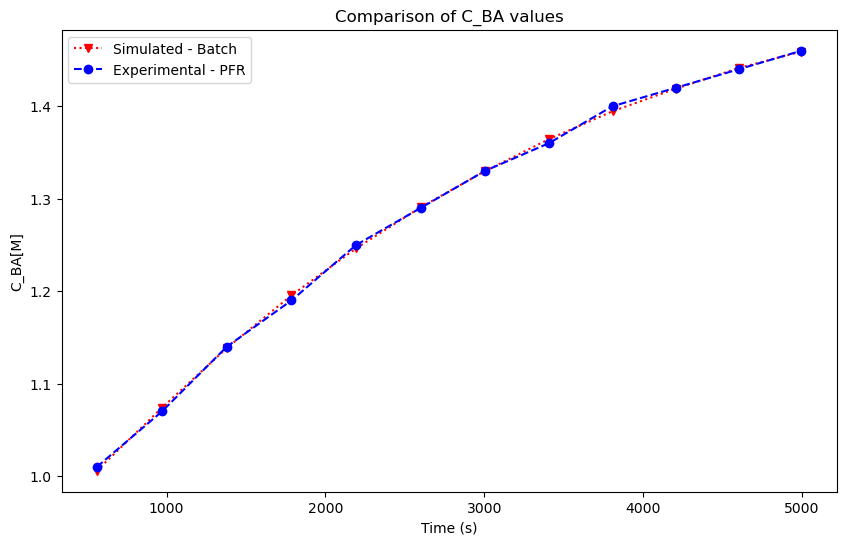

In [43]:
num_exp = len(ramp_FT)
C_FT_sim = []
for i in range(num_exp):
    BA_FT_exp = BatchSimulateFT(ramp_FT.iloc[i])
    BA_FT_model = BA_FT_exp.get_labeled_model()
    solved_model_FT = BA_FT_exp.simulate()
    t_ind = list(solved_model_FT.t)[-1] # 
    # print(t_ind)
    C_FT = solved_model_FT.C_BA[t_ind].value
    C_FT_sim.append(C_FT)

C_FT_sim

# Plotting the simulated and experimental data for FT case
fig, ax = plt.subplots(figsize=(10, 6))

# BATCH DATA
ax.plot(ramp_FT["t_L(s)"], C_FT_sim, "rv:", label="Simulated - Batch")

# Experimental Data
ax.plot(ramp_FT["t_L(s)"], ramp_FT["C_BA(M)"], "bo--", label="Experimental - PFR")

# Setting labels and title
ax.set_xlabel("Time (s)")
ax.set_ylabel("C_BA[M]")
ax.set_title("Comparison of C_BA values")
ax.legend()

# DOE
## Batch Model

In [44]:
theta_bat_dict =theta_bat.to_dict()

In [45]:
exp_b = PFRasBatch(ramp_F1, theta_initial=theta_bat_dict, C_BA0=1.56)
doe_b = DesignOfExperiments(exp_b, objective_option="determinant", tee=True)
FIM_b = doe_b.compute_FIM()
print("FIM of the experiment using Batch Model:")
print(FIM_b)

FIM of the experiment using Batch Model:
[[28.99530592 -3.3122006 ]
 [-3.3122006   0.37836046]]


### Full Factorial Design

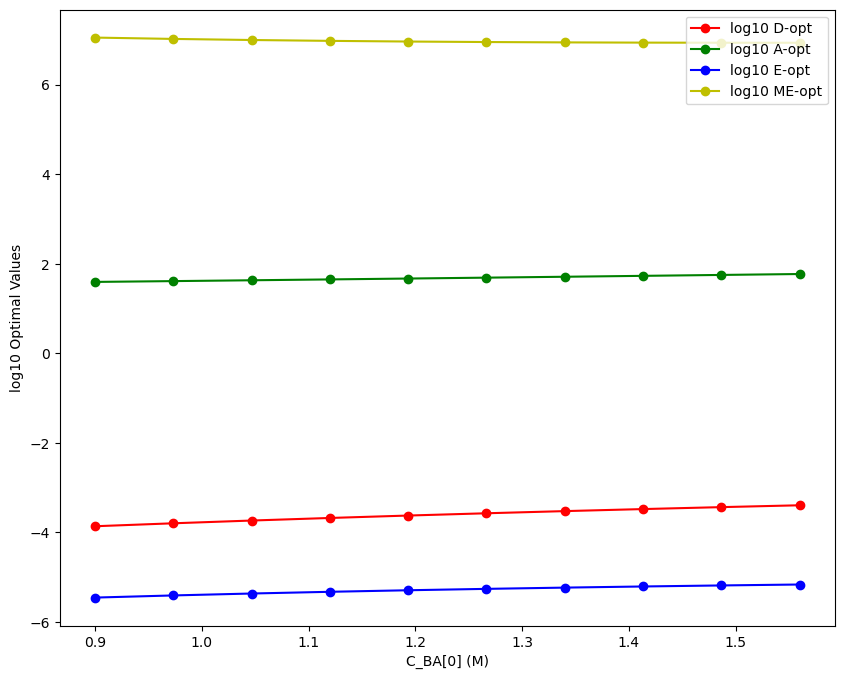

In [46]:
doe_obj_FF = DesignOfExperiments(
    exp_b,
    prior_FIM=FIM_b
)
design_ranges = {"C_BA[0]":[0.9, 1.56, 10]}  #, "T":[(70 + 273.15), (140 + 273.15), 5]
FF_design = doe_obj_FF.compute_FIM_full_factorial(design_ranges=design_ranges, method="kaug")

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 8))
C_BA0_FF = FF_design["C_BA[0]"]
ax.plot(C_BA0_FF, FF_design['log10 D-opt'], 'ro-', label='log10 D-opt')
ax.plot(C_BA0_FF, FF_design['log10 A-opt'], 'go-', label='log10 A-opt')
ax.plot(C_BA0_FF, FF_design['log10 E-opt'], 'bo-', label='log10 E-opt')
ax.plot(C_BA0_FF, FF_design['log10 ME-opt'], 'yo-', label='log10 ME-opt')
ax.set_xlabel('C_BA[0] (M)')
ax.set_ylabel('log10 Optimal Values')
ax.legend()

In [47]:
# run doe for a single experiment
# doe_obj_FF.run_doe()
# get results of run_doe()
# doe_obj_FF.results